# Binary Similarity Notebooks

Nomenclature: BinSim_Analysis_Datasets,variety number_filtering (multiple if multiple datasets with different filters are being used)

Variety number only used for grapevine Datasets

In this case, BinSim_Analysis_GD11_all2_groups2all1.ipynb

Peak Filtering and Alignments explained after imports

## Organization of the Notebook

- Imports and Presentation of the Grapevine datasets filtering/alignments analysed in this notebook
- Reading the two filtering/alignments (Negative and Positive grapevine datasets for each alignment)
- Performing the different pre-treatments (including BinSim) on the datasets
- Preliminary analysis on the 1st alignment set of datasets
- Agglomerative Hierarchical Clustering and K-means Clustering (both alignments)
- Random Forest - optimization, predictive accuracy and important features (1st alignment only)
- PLS-DA - optimization, predictive accuracy and important features (1st alignment only)
- Permutation Tests
- Feature Permutation Tests (Incomplete)

## Notebook with Dissertation Figures

### Needed Imports

In [1]:
import numpy as np
import pandas as pd
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import seaborn as sns
import itertools

# Metabolinks package
import metabolinks as mtl
import metabolinks.transformations as transf
from metabolinks.similarity import mz_similarity

# Python files in the repository
import scaling as sca
import multianalysis as ma

C:\Users\francisco\Anaconda3\lib\site-packages\xarray\core\merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
%matplotlib inline

# Similarity analysis with BinSim and different combinations of traditional pre-treatments - Grapevine

## Peak Alignment and Peak Filtering was performed with an in-house Python script available in the metabolinks package (see peak_alignments.ipynb notebook)

### 1st Filtering/Alignment: Feature present in at least two samples in the dataset - min_sample = 2 with all samples of the dataset - Name: all2 or 1-2

### 2nd Filtering/Alignment: Feature present in at least two of the three samples of any biological group in the dataset - 2 successive alignments - 1st alignment (between samples of a group): min_sample = 2, 2nd alignment (between all samples): min_sample = 1 - NAME: group2all1 or 2-1

To better understand the functions used outside of normal Python packages, see scaling.py and multianalysis.py where they are better described.

## Similarity analysis

Grapevine Datasets have a total of 33 samples and 11 biological groups - grapevine varieties (3 samples per group).

Negative Grapevine Dataset = Negative GD or NGD

Positive Grapevine Dataset = Positive GD or PGD

Binary Similarity = BinSim

#### Datasets

aligned_all_neg = Negative GD alignment 1-2 / bin_neg - binary matrix equivalent

aligned_all_pos = Positive GD alignment 1-2 / bin_pos - binary matrix equivalent

aligned_all_neg2 = Negative GD alignment 2-1 / bin_neg2 - binary matrix equivalent

aligned_all_pos2 = Positive GD alignment 2-1 / bin_pos2 - binary matrix equivalent

### Read aligned data of the 1st Alignment 1-2

In [3]:
# From the alignments_new store
aligned_all_pos = pd.HDFStore('alignments_new.h5').get('all_1ppm_min2_pos')
aligned_all_neg = pd.HDFStore('alignments_new.h5').get('all_1ppm_min2_neg')

### Read aligned data of the 2nd Alignment 2-1

In [4]:
# From the alignments_new store
aligned_all_pos2 = pd.HDFStore('alignments_new.h5').get('groups_1ppm_min2_all_1ppm_pos')
aligned_all_neg2 = pd.HDFStore('alignments_new.h5').get('groups_1ppm_min2_all_1ppm_neg')

### Global metadata for consistency between tables and plots

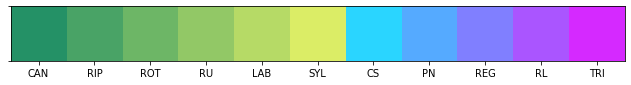

In [5]:
# Useful data
sample_names = aligned_all_neg.cdl.samples
all_labels = aligned_all_neg.cdl.labels
unique_labels = aligned_all_neg.cdl.unique_labels

# customize these colors
colours = sns.color_palette('summer', 6)
colours.extend(sns.color_palette('cool', 5))
ordered_unique_labels = ('CAN','RIP','ROT','RU','LAB','SYL','CS','PN','REG','RL','TRI')

label_colors = {lbl: c for lbl, c in zip(ordered_unique_labels, colours)}

sns.palplot(label_colors.values())
new_ticks = plt.xticks(range(len(ordered_unique_labels)), ordered_unique_labels)

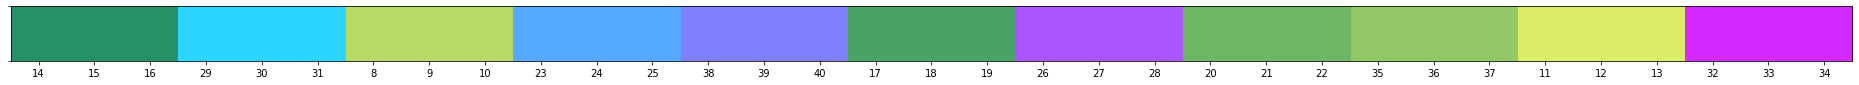

In [6]:
sample_colors = {s: label_colors[lbl] for s, lbl in zip(sample_names, all_labels)}

sns.palplot(sample_colors.values())
new_ticks = plt.xticks(range(len(sample_names)), sample_names)

## Data transformations and pre-treatments

### Each Dataset is transformed to binary or treated by a combination of more established treatments


### Traditional Pre-Treatments

All samples need to have missing value imputation (removing features is optional). In this case, missing features were replaced with half of the minimum intensity of the full dataset.

This can be done with the `NaN_Imputation` function of scaling.py or `fillna_frac_min`(more options available) from metabolinks.

#### 3/4 types of combinations of traditional pre-treatments are made:

(Imp (Ionly) - Only Missing Value Imputation).

##### P Treatment - Missing Value Imputation and Pareto Scaling.

##### NP Treatment - Missing Value Imputation, Normalization by reference feature and Pareto Scaling.

##### NGP Treatment - Missing Value Imputation, Normalization by reference feature, Generalized Logarithmic Transformation and Pareto Scaling.

Note: Leucine Enkephalin peak is removed upon normalization.

### Binary Similarity

##### BinSim - `df_to_bool` function (very simple)

In [7]:
# Represents Binary Similarity pre-treatment
def df_to_bool(df):
    "Transforms data into 'binary' matrices."
    return df.mask(df.notnull(), 1).mask(df.isnull(), 0)


def compute_transf(dataset, norm_ref=None, lamb=None):
    "Computes 3 combinations of pre-treatments and BinSim and returns after treatment datasets in a dict."
    
    intensities = dataset
    dicto = {}
    
    # Imputation of Missing Values
    imputed = transf.fillna_frac_min(intensities, fraction=0.5)
    
    # Normalization by a reference feature
    if norm_ref is not None:
        norm = transf.normalize_ref_feature(imputed, norm_ref, remove=True)
    else:
        norm = imputed
    
    # Pareto Scaling and Generalized Logarithmic Transformation
    P = transf.pareto_scale(imputed)
    NP = transf.pareto_scale(norm)
    NGP = transf.pareto_scale(transf.glog(norm, lamb=lamb))
    
    # Store results
    dicto['binary'] = df_to_bool(intensities)
    dicto['Ionly'] = imputed
    dicto['P'] = P
    dicto['NP'] = NP
    dicto['NGP'] = NGP
    
    return dicto

Human leucine enkephalin (Sigma Aldrich) is the reference feature (internal standard) used for these datasets

[M+H]+ = 556.276575 Da or [M-H]- = 554.262022 Da

Search in the Negative GD and Positive GD for the reference feature with `search_for_ref_feat` (details in scaling.py).

### 1st Filtering/Alignment - 1-2 (used in dissertation)

#### Performing different combinations of pre-treatments for the Negative and Positive GD

Search for the reference feature.

In [8]:
# Theoretical mass for negative mode Leucine Enkephalin - 554.262022.
RefEst_Neg = sca.search_for_ref_feat(aligned_all_neg, 554.262022) # see if the function gives the reference feature
print(RefEst_Neg) # It did! (m/z peak, distance to theoretical mass)

# Theoretical mass for positive mode Leucine Enkephalin - 556.276575.
RefEst_Pos = sca.search_for_ref_feat(aligned_all_pos, 556.276575)
print(RefEst_Pos)

(554.26202, 1.9999999949504854e-06)
(556.27657, 4.9999999873762135e-06)


Apply the different pre-treatments and get the results in their respective dictionaries

In [9]:
# Negative mode dataset
treat_neg = compute_transf(aligned_all_neg, norm_ref = 554.26202)

# Positive mode dataset
treat_pos = compute_transf(aligned_all_pos, norm_ref = 556.276575)

### 2nd Filtering/Alignment - 2-1

#### Performing different combinations of pre-treatments for the Negative and Positive GD

Search for the reference feature.

In [10]:
#Theoretical mass for negative mode Leucine Enkephalin - 554.262022.
RefEst_Neg = sca.search_for_ref_feat(aligned_all_neg2, 554.262022) #see if the function gives the reference feature
print(RefEst_Neg) #It did!

#Theoretical mass for positive mode Leucine Enkephalin - 556.276575.
RefEst_Pos = sca.search_for_ref_feat(aligned_all_pos2, 556.276575)
print(RefEst_Pos)

(554.26202, 1.9999999949504854e-06)
(556.27657, 4.9999999873762135e-06)


Apply the different pre-treatments and get the results in their respective dictionaries

In [11]:
# Negative mode dataset
treat_neg2 = compute_transf(aligned_all_neg2, norm_ref = 554.26202)

# Positive mode dataset
treat_pos2 = compute_transf(aligned_all_pos2, norm_ref = 556.27657)

## Preliminary Similiarity analysis on the 1st Alignment 

### Compute m/z similarities

In [12]:
sim_pos = mz_similarity(aligned_all_pos, has_labels = True)
sim_neg = mz_similarity(aligned_all_neg, has_labels = True)

In [13]:
#print(sim_pos)

In [14]:
#print(sim_neg)

### Clustermap peak list function

In [15]:
def clustermap_peak_list(aligned):
    aligned_01 = aligned.copy()
    aligned_01[aligned_01.notnull()] = 1
    aligned_01[aligned_01.isnull()] = 0
    aligned_01.columns = aligned_01.cdl.samples

    ulabels = aligned.cdl.unique_labels
    n = len(ulabels)
    
    p = sns.color_palette() + sns.color_palette("Set1", n_colors=n-10, desat=.5)
    sample_to_labels = pd.Series(aligned.cdl.labels, index=aligned.cdl.samples)
    label_colors = pd.Series(p, index=ulabels)
    sample_colors = sample_to_labels.map(label_colors)
    
    g = sns.clustermap(aligned_01, metric="jaccard", figsize=(15, 20), 
                       row_cluster=False,
                       col_colors=sample_colors,
                       yticklabels=False)
    # fix bug in seaborn, error in clustermap if cbar == False
    ax=g.cax; aax=ax.clear(); aax = ax.axis('off'); 

    # draw legend
    lpatches = [mpatches.Patch(color=c, label=lbl) for (lbl, c) in label_colors.iteritems()]
    leg = plt.legend(handles=lpatches, fontsize=20)
    return g
    

Sample HC, NEGATIVE mode


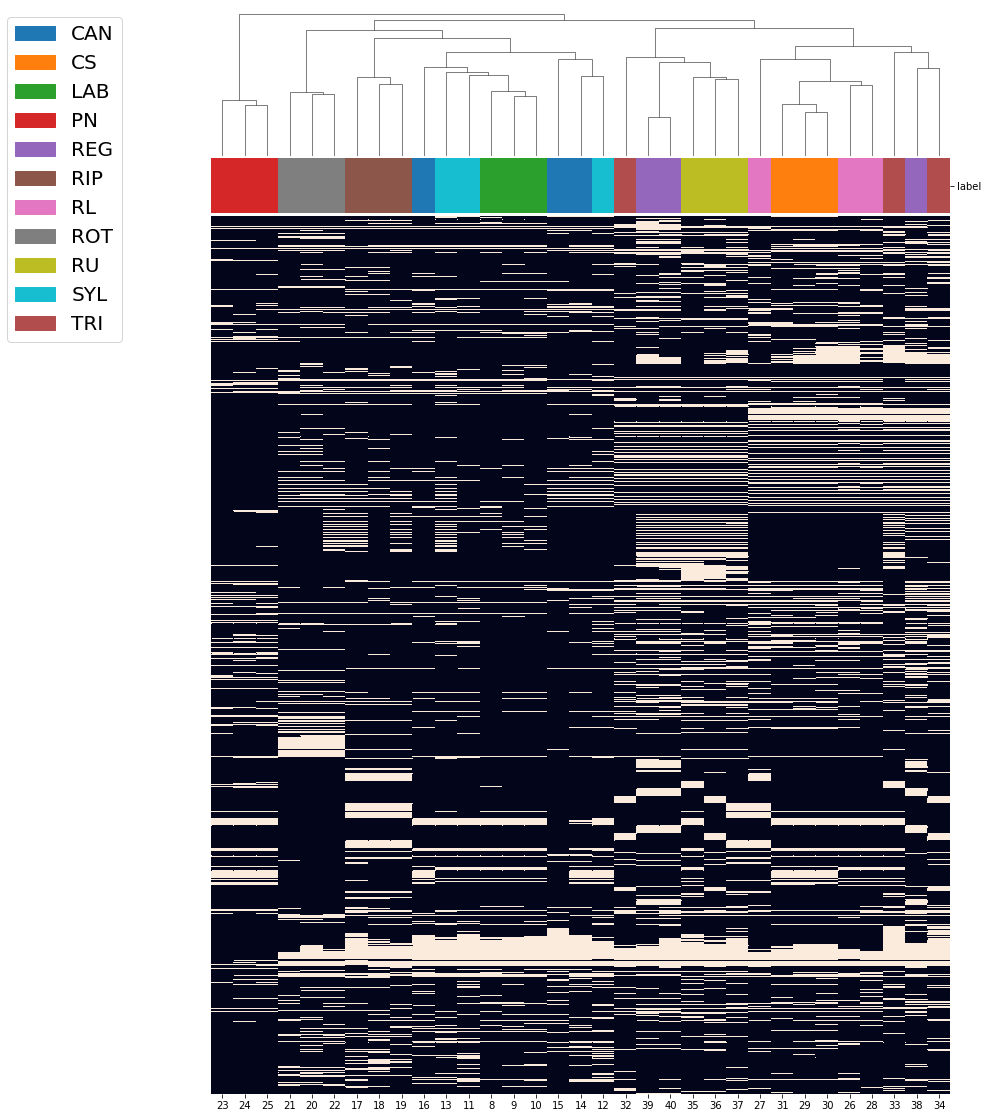

In [16]:
print('Sample HC, NEGATIVE mode')
g = clustermap_peak_list(aligned_all_neg)

Sample HC, POSITIVE mode


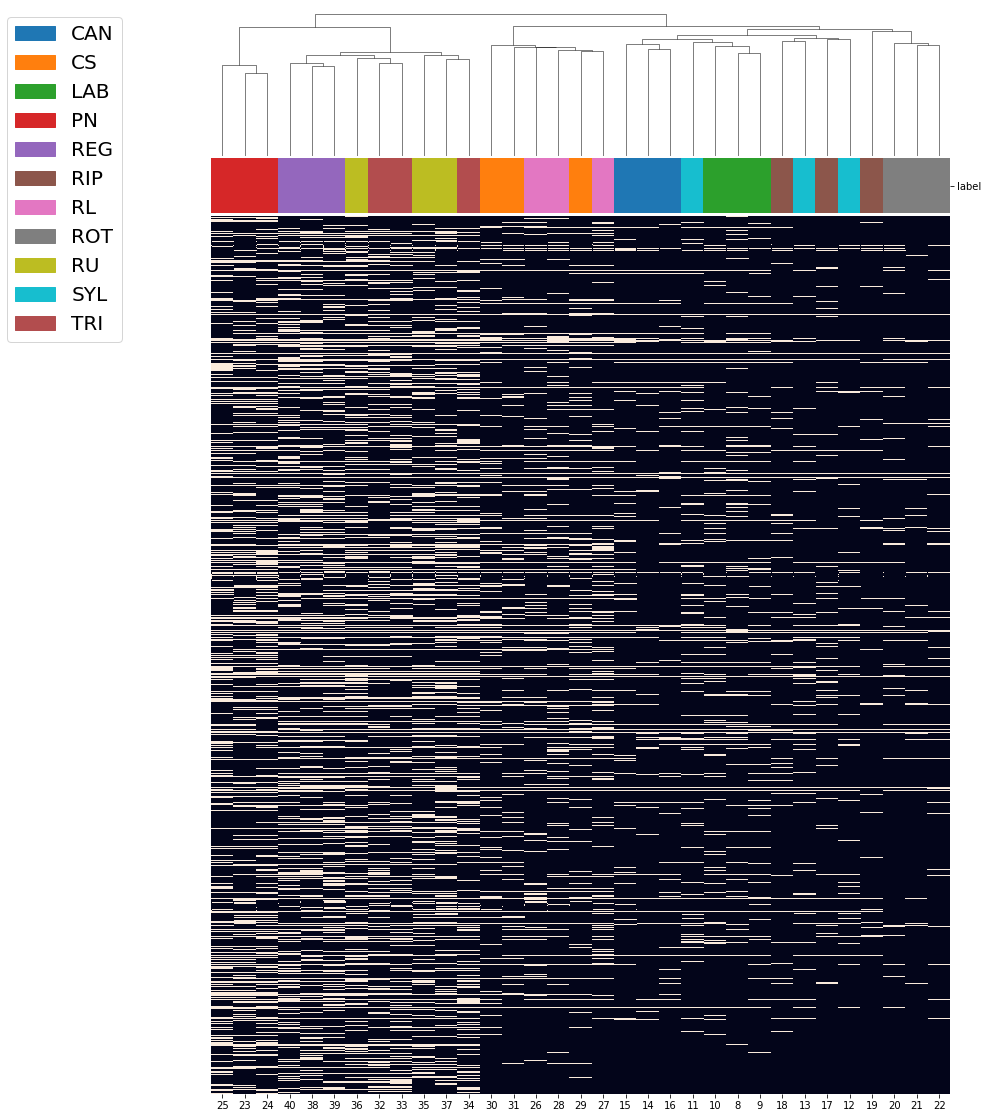

In [17]:
print('Sample HC, POSITIVE mode')
g = clustermap_peak_list(aligned_all_pos)

### Similarity analysis (Jaccard)

Similarity fast analysis made based on the Jaccard Dissimilarities between the samples and the groups in the datasets.

Use of `mz_similarity` of metabolinks package.

In [18]:
def plot_jaccard_sims(dataset, title=''):
    "Plot heatmaps with sample and group similarity in the dataset."
    
    intensities = dataset
    sims = mz_similarity(intensities, has_labels=True)
    #grid_kws = {"height_ratios": (0.4, 0.4, 0.02)}
    f, ax = plt.subplots(1,2, figsize=(14, 7), constrained_layout=True) # gridspec_kw=grid_kws,
    
    # Draw Heatmaps
    hm = sns.heatmap(sims.sample_similarity_jaccard, annot=False, square=True, ax=ax[0], cmap='YlGnBu', cbar=None)
    hm = sns.heatmap(sims.label_similarity_jaccard, annot=True, square=True, ax=ax[1], cmap='YlGnBu')
    
    # Correction for heatmap bug in latest version of seaborn
    bottom, top = ax[0].get_ylim()
    ax[0].set_ylim(bottom + 0.5, top - 0.5)
    bottom, top = ax[1].get_ylim()
    ax[1].set_ylim(bottom + 0.5, top - 0.5)
    
    ax[0].set_title('Sample similarity')
    ax[1].set_title('Group similarity')
    f.suptitle(title, fontsize=16)

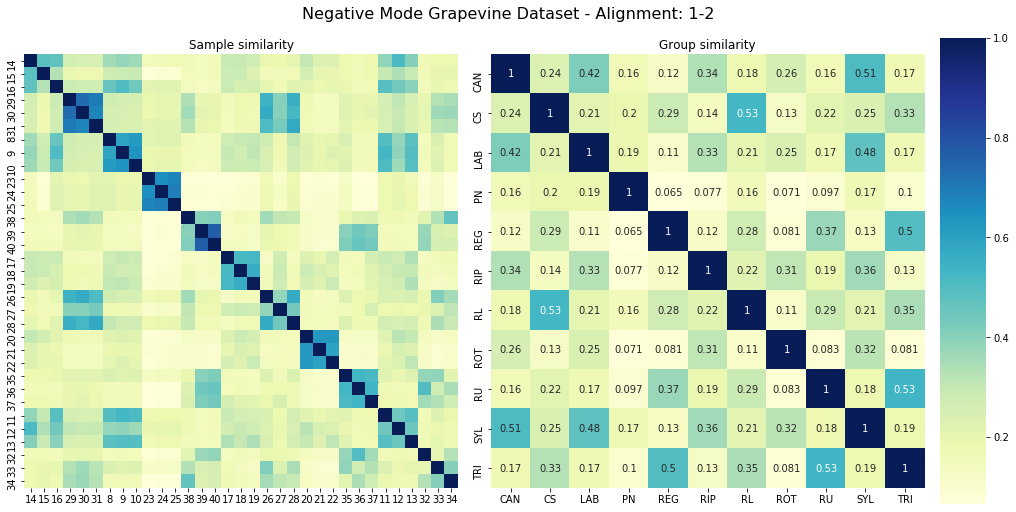

In [19]:
plot_jaccard_sims(aligned_all_neg, 'Negative Mode Grapevine Dataset - Alignment: 1-2')

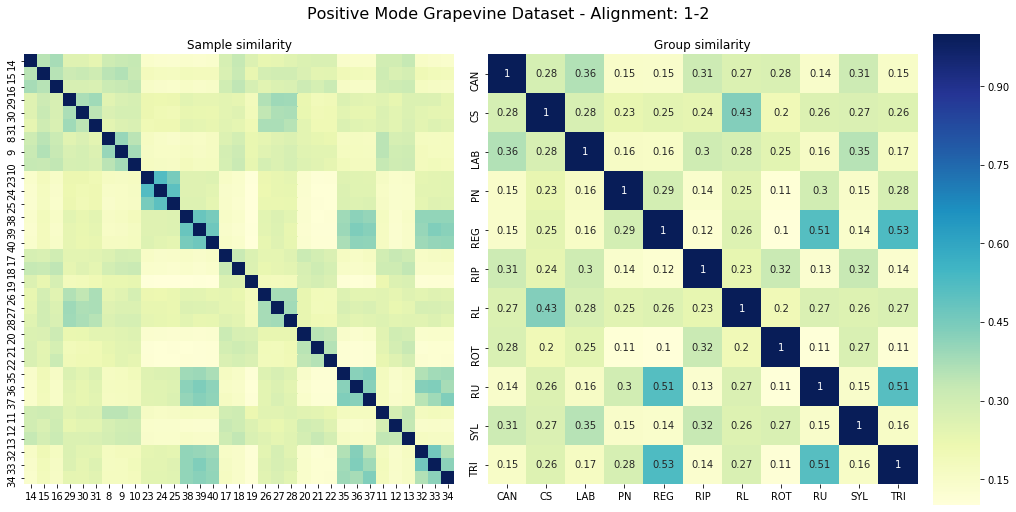

In [20]:
plot_jaccard_sims(aligned_all_pos, 'Positive Mode Grapevine Dataset - Alignment: 1-2')

#### Verification that `dist.pdist()` produces the same result as `mz_similarity()`

In [21]:
intensities = aligned_all_neg
neg_01 = treat_neg['binary']

scipy_jdist = dist.pdist(neg_01.T, metric='jaccard')
df_scipy_dist = pd.DataFrame(dist.squareform(scipy_jdist), index=sample_names, columns=sample_names)

#sim_neg = mz_similarity(intensities, has_labels=True)
jsim = sim_neg.sample_similarity_jaccard
#jsim.index.name = 'Sample'
#jsim.columns.name = 'Sample'
jdist = 1 - jsim

from pandas.testing import assert_frame_equal
assert_frame_equal(jdist, df_scipy_dist)
# No exception should be raised!

#### Agglomerative Hierarchical Clustering Analysis made based on Group Similarity

Dendrogram from Jaccard distance, Negative mode Grapevine dataset - Alignment: 1-2 (cophenetic = 0.93529)


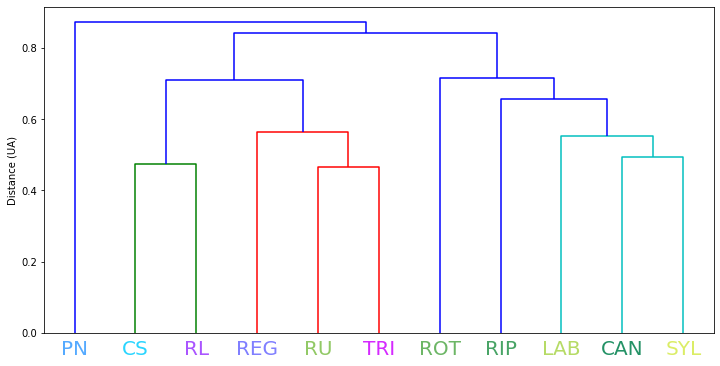

In [22]:
# Calculating the Jaccard distance matrix (between the samples) of the dataset and build the linkage matrix of the HCA
jdist = dist.squareform(1 - sim_neg.label_similarity_jaccard.values)
Z = hier.linkage(jdist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z,jdist)[0]
print(f'Dendrogram from Jaccard distance, Negative mode Grapevine dataset - Alignment: 1-2 (cophenetic = {coph:.5f})')

# Plot the dendrogram
fig = plt.figure(figsize=(12,6))
dn = hier.dendrogram(Z, labels=unique_labels, leaf_font_size=20, above_threshold_color='b')

# Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

Dendogram from Jaccard distance, Positive mode Grapevine dataset - Alignment: 1-2 (cophenetic = 0.89942)


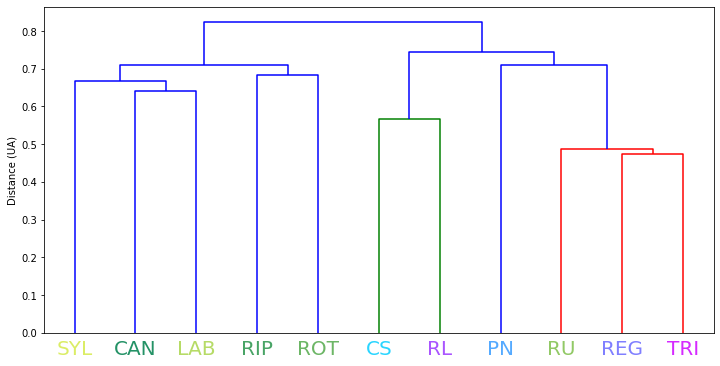

In [23]:
# Calculating the Jaccard distance matrix (between the samples) of the secondary dataset and build the linkage matrix of the HCA
jdist = dist.squareform(1 - sim_pos.label_similarity_jaccard.values)
Z = hier.linkage(jdist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z,jdist)[0]
print(f'Dendogram from Jaccard distance, Positive mode Grapevine dataset - Alignment: 1-2 (cophenetic = {coph:.5f})')

# Plot the dendrogram
fig = plt.figure(figsize=(12,6))
dn = hier.dendrogram(Z, labels=unique_labels, leaf_font_size=20, above_threshold_color='b')

# Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

# Unsupervised Statistical Analysis - Both Alignments

## (Agglomerative) Hierarchical Cluster Analysis 

HCA analysis and plotting dendrograms of each differently-treated dataset.

Dendrograms were plotted with Euclidian distance metric and UPGMA linkage for datasets treated with traditional pre-treatments.

Dendrograms were plotted with different binary distance metrics (Jaccard as example) and UPGMA linkage for datasets treated with BinSim.

In [24]:
def plot_dendogram(Z, title='', color_threshold=None):
    """Plot a dendrogram from a Z linkage matrix with a chosen title and a chosen color_threshold."""
    
    plt.rcParams['lines.linewidth'] = 1.3
    
    fig = plt.figure(figsize=(10,6))
    dn = hier.dendrogram(Z, labels=all_labels, leaf_font_size=13, above_threshold_color='b', leaf_rotation=45,
                         color_threshold=color_threshold)#,  orientation='left')
    
    # Coloring labels
    ax = plt.gca()
    ax.set_ylabel('Distance (UA)')
    ax.set_title(title, fontsize = 16)
    xlbls = ax.get_xmajorticklabels()

    for lbl in xlbls:
        lbl.set_color(label_colors[lbl.get_text()])
    

## Negative Mode GD - 1-2 Alignment/Filtering - Dendrograms of each differently-treated NGD

## Part of Fig. 3.1

Feature appears at least in 2 samples of the 33 samples in the dataset. 1_2 in figures where it appears with other datasets.

In [25]:
# Missing Value Imputation only
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
Imp_neg = treat_neg['Ionly']
dist_Imp_neg = dist.pdist(Imp_neg.T, metric = 'euclidean')
Z_Imp_neg = hier.linkage(dist_Imp_neg, method = 'average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
#coph = hier.cophenet(Z_Imp_neg, dist_Imp_neg)[0]

# Plot the dendrogram
#title = f'NaN Imputation only'
#plot_dendogram(Z_Imp_neg, title)

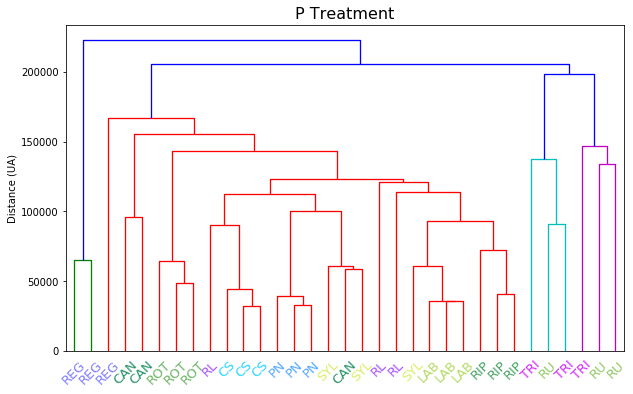

In [26]:
# Imputed and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
P_neg = treat_neg['P']
dist_P_neg = dist.pdist(P_neg.T, metric = 'euclidean')
Z_P_neg = hier.linkage(dist_P_neg, method = 'average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_neg, dist_P_neg)[0] #method average seems to lead to higher coefficients

# Plot the dendrogram
title = f'P Treatment'
plot_dendogram(Z_P_neg, title, color_threshold = 175000)
#plt.savefig('Dendro-NGD-P')

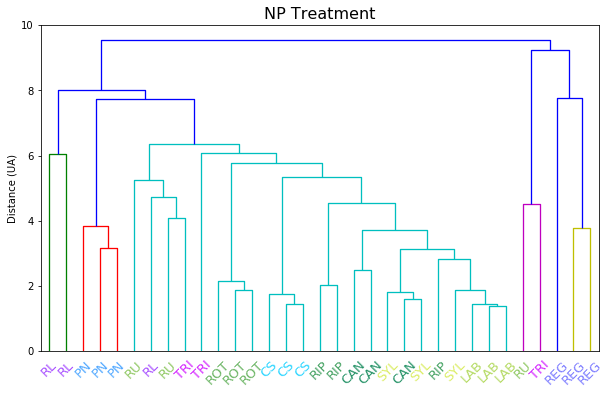

In [27]:
# Imputed, Normalized (reference feature) and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
NP_neg = treat_neg['NP']
dist_NP_neg = dist.pdist(NP_neg.T, metric = 'euclidean')
Z_NP_neg = hier.linkage(dist_NP_neg, method = 'average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NP_neg, dist_NP_neg)[0] #method average seems to lead to higher coefficients

# Plot the dendrogram
title = f'NP Treatment'
plot_dendogram(Z_NP_neg, title)
#plt.savefig('Dendro-NGD-NP')

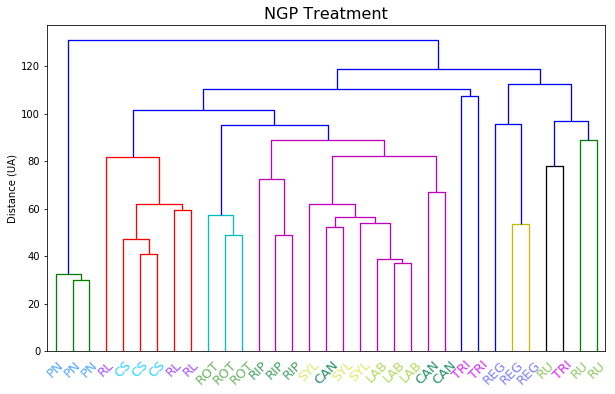

In [28]:
# Imputed, Normalized (reference feature), glog transformed and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
NGP_neg = treat_neg['NGP']
dist_NGP_neg = dist.pdist(NGP_neg.T, metric = 'euclidean')
Z_NGP_neg = hier.linkage(dist_NGP_neg, method = 'average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_neg, dist_NGP_neg)[0]

# Plot the dendrogram
title = f'NGP Treatment'
plot_dendogram(Z_NGP_neg, title)
#plt.savefig('Dendro-NGD-NGP')

### Binary Similarity (BinSim) Pre-Treatment - Example Dendogram with Jaccard Dissimilarity (Negative GD)

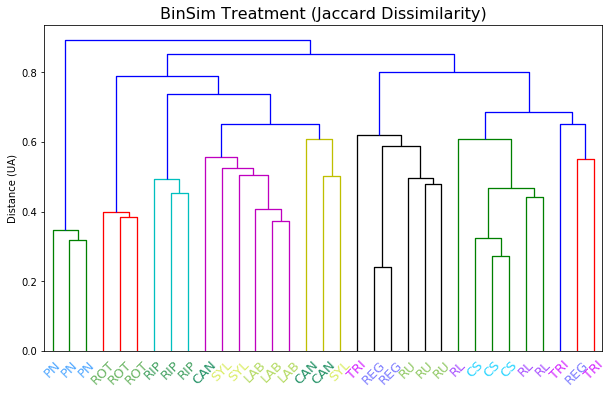

In [29]:
# BinSim
binary = treat_neg['binary']

# Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
Z_bin = hier.linkage(binary.T, metric='jaccard', method='average')

# Plot the dendrogram
title = f'BinSim Treatment (Jaccard Dissimilarity)'
plot_dendogram(Z_bin, title)
#plt.savefig('Dendro-NGD-BinSim')

## Positive Mode GD - 1-2 Alignment/Filtering - Dendrograms of each differently-treated PGD

## Part of Suppl. Fig. 6.1

In [30]:
# Missing Value Imputation only
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
Imp_pos = treat_pos['Ionly']
dist_Imp_pos = dist.pdist(Imp_pos.T, metric = 'euclidean')
Z_Imp_pos = hier.linkage(dist_Imp_pos, method = 'average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
#coph = hier.cophenet(Z_Imp_pos, dist_Imp_pos)[0]

# Plot the dendrogram
#title = f'Positive Mode Grapevine Dataset (2-1), Euclidean, NaN Imputation, cophenetic={coph:.4f}'
#plot_dendogram(Z_Imp_pos, title)

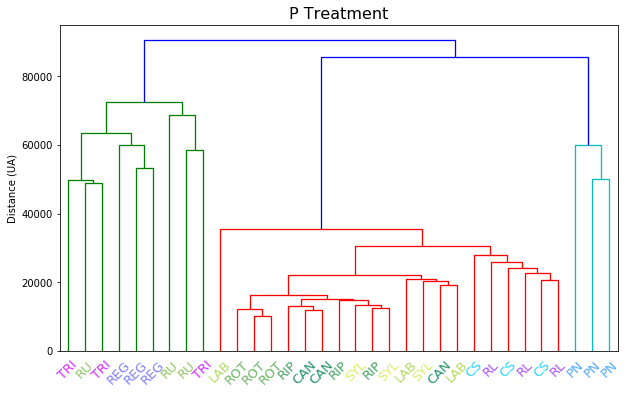

In [31]:
# Imputed and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
P_pos = treat_pos['P']
dist_P_pos = dist.pdist(P_pos.T, metric = 'euclidean')
Z_P_pos = hier.linkage(dist_P_pos, method = 'average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_pos, dist_P_pos)[0] 

# Plot the dendrogram
title = f'P Treatment'
plot_dendogram(Z_P_pos, title, color_threshold = 80000)
#plt.savefig('Dendro-PGD-P')

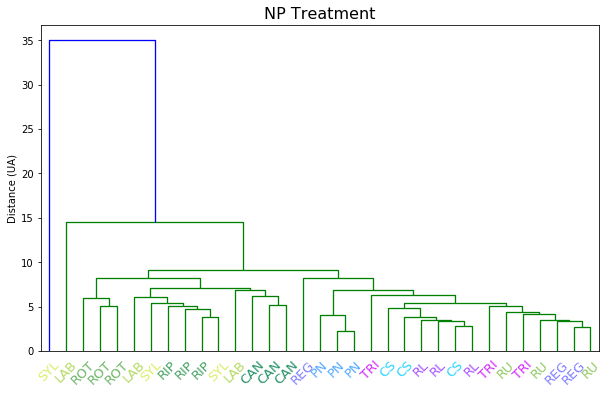

In [32]:
# Imputed, Normalized (reference feature) and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
NP_pos = treat_pos['NP']
dist_NP_pos = dist.pdist(NP_pos.T, metric = 'euclidean')
Z_NP_pos = hier.linkage(dist_NP_pos, method = 'average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NP_pos, dist_NP_pos)[0]

# Plot the dendrogram
title = f'NP Treatment'
plot_dendogram(Z_NP_pos, title)
#plt.savefig('Dendro-PGD-NP')

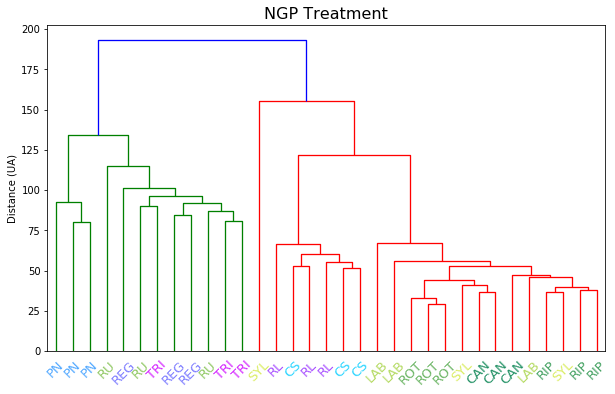

In [33]:
# Imputed, Normalized (reference feature), glog transformed and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
NGP_pos = treat_pos['NGP']
dist_NGP_pos = dist.pdist(NGP_pos.T, metric = 'euclidean')
Z_NGP_pos = hier.linkage(dist_NGP_pos, method = 'average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_pos, dist_NGP_pos)[0] 

# Plot the dendrogram
title = f'NGP Treatment'
plot_dendogram(Z_NGP_pos, title, color_threshold = 175)
#plt.savefig('Dendro-PGD-NGP')

### Binary Similarity (BinSim) Pre-Treatment - Example Dendogram with Jaccard Dissimilarity (Positive GD)

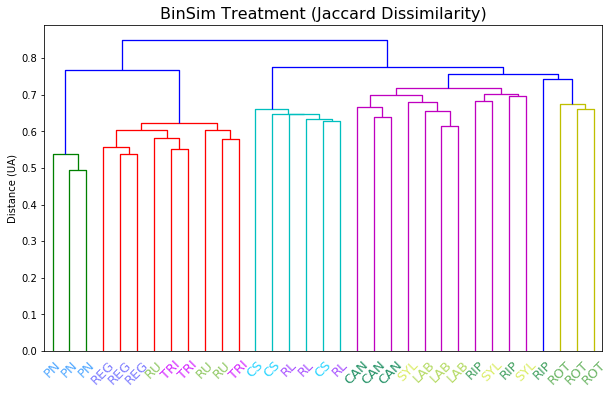

In [34]:
binary = treat_pos['binary']

# Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
Z_bin = hier.linkage(binary.T, metric='jaccard', method='average')

# Plot the dendrogram
title = f'BinSim Treatment (Jaccard Dissimilarity)'
plot_dendogram(Z_bin, title, color_threshold = 0.73)
#plt.savefig('Dendro-PGD-BinSim')

## Negative Mode GD - 2-1 Alignment/Filtering - Dendrograms of each differently-treated NGD

Feature appears at least in 2 samples of any of the 11 grapevine varieties in the dataset. 2_1 in figures where it appears with other datasets.

In [35]:
# Missing Value Imputation only
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
Imp_neg2 = treat_neg2['Ionly']
dist_Imp_neg2 = dist.pdist(Imp_neg2.T, metric = 'euclidean')
Z_Imp_neg2 = hier.linkage(dist_Imp_neg2, method = 'average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
#coph = hier.cophenet(Z_Imp_neg2, dist_Imp_neg2)[0]

# Plot the dendrogram
#title = f'Negative Mode Grapevine Dataset (2-1), Euclidean, NaN Imputation, cophenetic={coph:.4f}'
#plot_dendogram(Z_Imp_neg2, title)

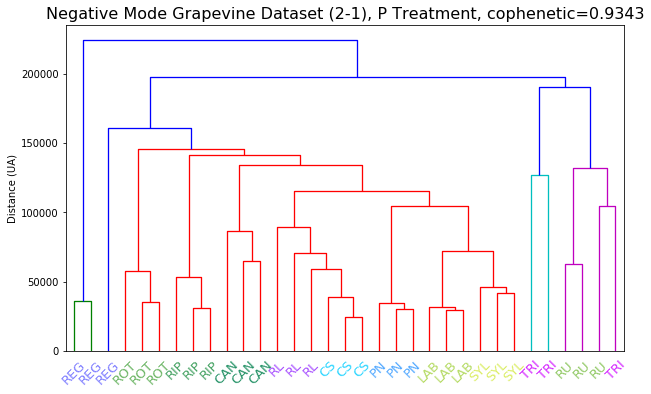

In [36]:
# Imputed and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
P_neg2 = treat_neg2['P']
dist_P_neg2 = dist.pdist(P_neg2.T, metric = 'euclidean')
Z_P_neg2 = hier.linkage(dist_P_neg2, method = 'average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_neg2, dist_P_neg2)[0] 

# Plot the dendrogram
title = f'Negative Mode Grapevine Dataset (2-1), P Treatment, cophenetic={coph:.4f}'
plot_dendogram(Z_P_neg2, title)

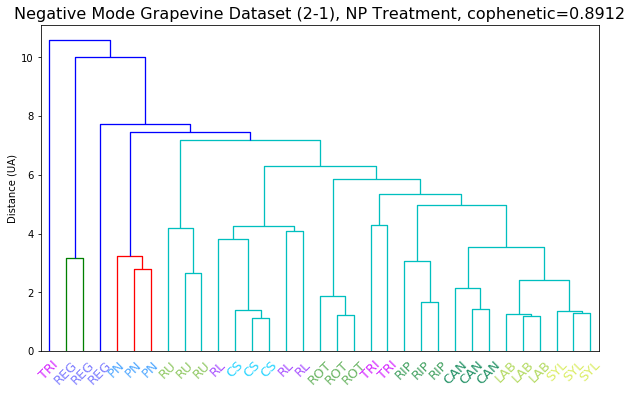

In [37]:
# Imputed, Normalized (reference feature) and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
NP_neg2 = treat_neg2['NP']
dist_NP_neg2 = dist.pdist(NP_neg2.T, metric = 'euclidean')
Z_NP_neg2 = hier.linkage(dist_NP_neg2, method = 'average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NP_neg2, dist_NP_neg2)[0]

# Plot the dendrogram
title = f'Negative Mode Grapevine Dataset (2-1), NP Treatment, cophenetic={coph:.4f}'
plot_dendogram(Z_NP_neg2, title)

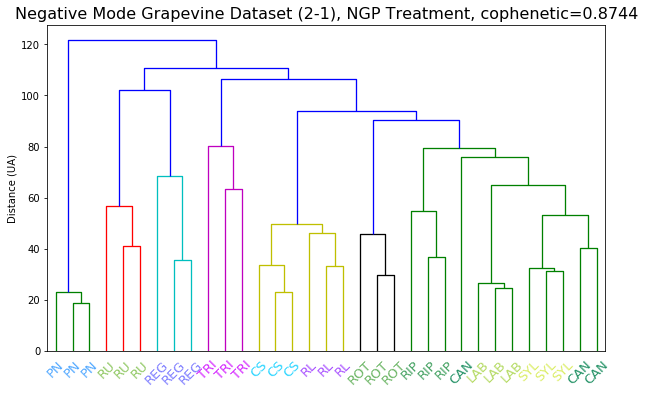

In [38]:
# Imputed, Normalized (reference feature), glog transformed and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
NGP_neg2 = treat_neg2['NGP']
dist_NGP_neg2 = dist.pdist(NGP_neg2.T, metric = 'euclidean')
Z_NGP_neg2 = hier.linkage(dist_NGP_neg2, method = 'average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_neg2, dist_NGP_neg2)[0]

# Plot the dendrogram
title = f'Negative Mode Grapevine Dataset (2-1), NGP Treatment, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_neg2, title)

### Binary Similarity (BinSim) Pre-Treatment - Example Dendogram with Jaccard Dissimilarity (Negative GD)

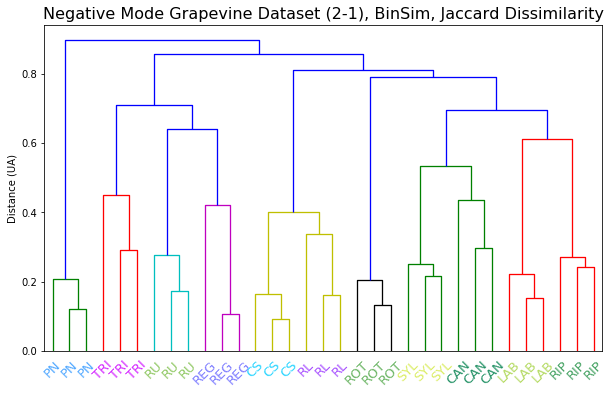

In [39]:
binary = treat_neg2['binary']

# Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
Z_bin = hier.linkage(binary.T, metric='jaccard', method='average')

# Plot the dendrogram
title = f'Negative Mode Grapevine Dataset (2-1), BinSim, Jaccard Dissimilarity'
plot_dendogram(Z_bin, title)

## Positive Mode GD - 2-1 Alignment/Filtering - Dendrograms of each differently-treated PGD

In [40]:
# Missing Value Imputation only
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
Imp_pos2 = treat_pos2['Ionly']
dist_Imp_pos2 = dist.pdist(Imp_pos2.T, metric = 'euclidean')
Z_Imp_pos2 = hier.linkage(dist_Imp_pos2, method = 'average') #ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
#coph = hier.cophenet(Z_Imp_pos2, dist_Imp_pos2)[0]

# Plot the dendrogram
#title = f'Positive Mode Grapevine Dataset (1-2), Euclidean, NaN Imputation, cophenetic={coph:.4f}'
#plot_dendogram(Z_Imp_pos2, title)

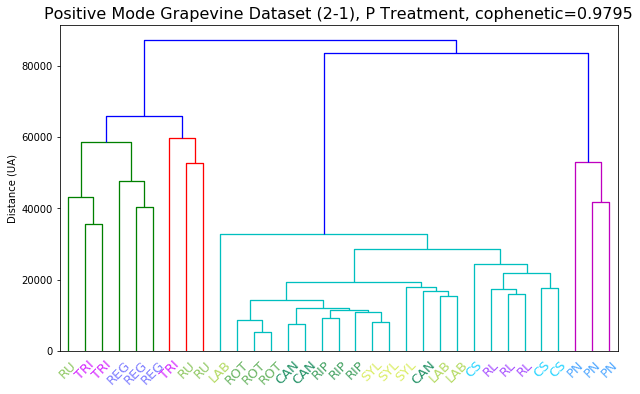

In [41]:
# Imputed and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
P_pos2 = treat_pos2['P']
dist_P_pos2 = dist.pdist(P_pos2.T, metric = 'euclidean')
Z_P_pos2 = hier.linkage(dist_P_pos2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_pos2, dist_P_pos2)[0]

# Plot the dendrogram
title = f'Positive Mode Grapevine Dataset (2-1), P Treatment, cophenetic={coph:.4f}'
plot_dendogram(Z_P_pos2, title)

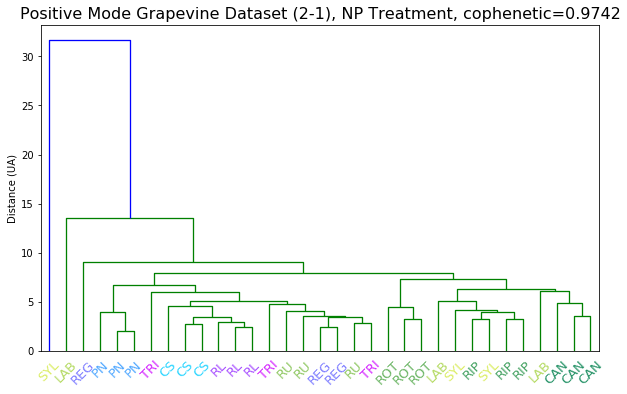

In [42]:
# Imputed, Normalized (reference feature) and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
NP_pos2 = treat_pos2['NP']
dist_NP_pos2 = dist.pdist(NP_pos2.T, metric = 'euclidean')
Z_NP_pos2 = hier.linkage(dist_NP_pos2, method = 'average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NP_pos2, dist_NP_pos2)[0] 

# Plot the dendrogram
title = f'Positive Mode Grapevine Dataset (2-1), NP Treatment, cophenetic={coph:.4f}'
plot_dendogram(Z_NP_pos2, title)

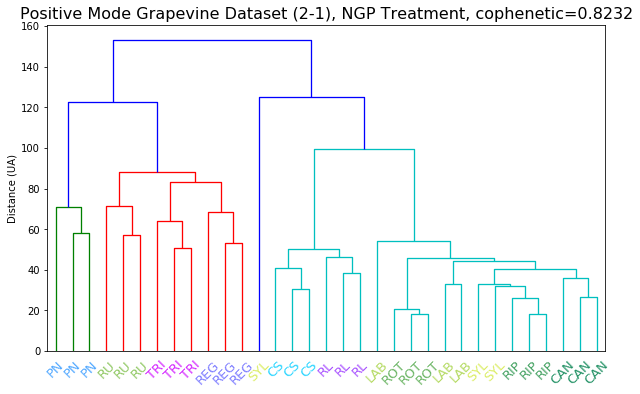

In [43]:
# Imputed, Normalized (reference feature), glog transformed and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
NGP_pos2 = treat_pos2['NGP']
dist_NGP_pos2 = dist.pdist(NGP_pos2.T, metric = 'euclidean')
Z_NGP_pos2 = hier.linkage(dist_NGP_pos2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_pos2, dist_NGP_pos2)[0] #method average seems to lead to higher coefficients

# Plot the dendrogram
title = f'Positive Mode Grapevine Dataset (2-1), NGP Treatment, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_pos2, title)

### Binary Similarity (BinSim) Pre-Treatment - Example Dendogram with Jaccard Dissimilarity (Positive GD)

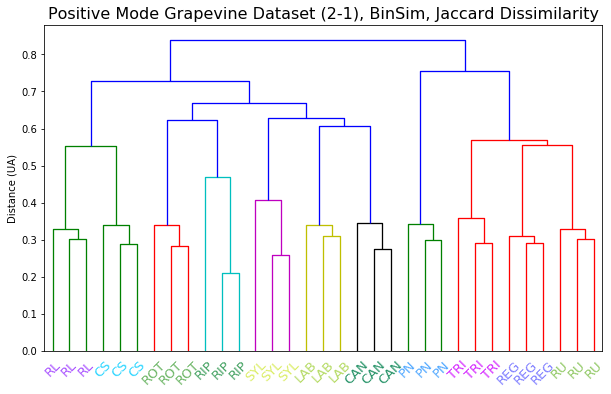

In [44]:
binary = treat_pos2['binary']

#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
Z_bin = hier.linkage(binary.T, metric='jaccard', method='average')

# Plot the dendrogram
title = f'Positive Mode Grapevine Dataset (2-1), BinSim, Jaccard Dissimilarity'
plot_dendogram(Z_bin, title)

### Similarity Comparison of the dendrograms made with all binary distance metrics and euclidean distances from the differently-treated datasets

#### Two methods: Cophenetic Correlation Coefficient and Baker's Gamma Correlation Coefficient

Baker's Gamma Correlation: Use of the `mergerank` function from multianalysis.py to create a 'rank' of the iteration number two samples were linked to the same cluster. Then see Kendall Correlation between the results from 2 dendrograms according to Baker's paper (Spearman Correlation according to R package 'dendextend').

Correlation Cophenetic Correlation: Pearson Correlation of the matrix of cophenetic distances of two different dendrograms.

### Traditionally-Treated Datasets - First Part (Until calculating correlations between dendrograms) of calculating the similarity coefficients

In [45]:
# Linkage Matrices of the different dendrograms built from the differently-treated datasets
Est_Treat_Z = (Z_P_neg, Z_NP_neg, Z_NGP_neg, Z_P_pos, Z_NP_pos, Z_NGP_pos,
            Z_P_neg2, Z_NP_neg2, Z_NGP_neg2, Z_P_pos2, Z_NP_pos2, Z_NGP_pos2)

# Condensed distance matrices between samples for each of the differently-treated datasets
dist_Est_Treat = (dist_P_neg, dist_NP_neg, dist_NGP_neg, dist_P_pos, dist_NP_pos, dist_NGP_pos,
                 dist_P_neg2, dist_NP_neg2, dist_NGP_neg2, dist_P_pos2, dist_NP_pos2, dist_NGP_pos2)

# Store results for the two metrics
K_BG = [] # Store mergerank results
S_BG = [] # For Baker's Gamma Correlation Coefficient
Coph_C = [] # For Cophenetic Correlation Coefficient

for i, (eu, d) in enumerate(zip(Est_Treat_Z, dist_Est_Treat)):
    K_BG.append(ma.mergerank(eu)) # Mergerank 
    S_BG.append(K_BG[i][K_BG[i]!=0]) # Both reshape to a 1D array (needed for Spearman correlation) and take out 0s 
    
    Coph_C.append(hier.cophenet(eu, d)) # Matrix of Cophenetic distances

#### Examples of procedure with these methods with the Negative Grapevine Dataset (Alignment 1-2)

#### Cophenetic Correlation Coefficient

In [46]:
# Apply np.corrcoef since cophenet function returns elements in the same order
print('Pair of samples      \tPearson Correlation \tp-value')
print('P Treat-NP Treat\t', stats.pearsonr(Coph_C[0][1],Coph_C[1][1])[0], '\t', stats.pearsonr(Coph_C[0][1],Coph_C[1][1])[1])
print('P Treat-NGP Treat\t', stats.pearsonr(Coph_C[0][1],Coph_C[2][1])[0], '\t', stats.pearsonr(Coph_C[0][1],Coph_C[2][1])[1])

Pair of samples      	Pearson Correlation 	p-value
P Treat-NP Treat	 0.6104807834038114 	 3.1088627739296713e-55
P Treat-NGP Treat	 0.5804288742812359 	 7.10512725048972e-49


#### Baker's Gamma Correlation Coefficient

According to Original Paper (Stability of Two Hierarchical Grouping Techniques Case 1: Sensitivity to Data Errors)

In [47]:
print('Pair of samples      \tKendall Correlation \tp-value')
print('P Treat-NP Treat\t', stats.kendalltau(S_BG[0],S_BG[1])[0], '\t', stats.kendalltau(S_BG[0],S_BG[1])[1])
print('P Treat-NGP Treat\t', stats.kendalltau(S_BG[0],S_BG[2])[0], '\t', stats.kendalltau(S_BG[0],S_BG[2])[1])

Pair of samples      	Kendall Correlation 	p-value
P Treat-NP Treat	 0.44330084075847676 	 2.817914814139397e-81
P Treat-NGP Treat	 0.3507141621651369 	 2.271962729046075e-50


According to the explanation given in the R package dendextend

In [48]:
print('Pair of samples      \tSpearman Correlation \tp-value')
print('P Treat-NP Treat\t', stats.spearmanr(S_BG[0],S_BG[1])[0], '\t', stats.spearmanr(S_BG[0],S_BG[1])[1])
print('P Treat-NGP Treat\t', stats.spearmanr(S_BG[0],S_BG[2])[0], '\t', stats.spearmanr(S_BG[0],S_BG[2])[1])

Pair of samples      	Spearman Correlation 	p-value
P Treat-NGP Treat	 0.5684413829491447 	 2.0541620452455514e-91
P Treat-NGP Treat	 0.4340345405568081 	 9.513613111794717e-50


### BinSim-Treated Datasets - First Part (Until calculating correlations between dendrograms) of calculating the similarity coefficients

### Note: Application only for the 1st Alignment/Filtering set of Negative and Positive dataset

Also building linkage matrices (HCA) using all different binary distance metrics.

Change between number of binary metrics to use.

In [49]:
# New denomination of BinSim treated datasets 
bin_neg = treat_neg['binary']
bin_pos = treat_pos['binary']
bin_neg2 = treat_neg2['binary']
bin_pos2 = treat_pos2['binary']

In [50]:
# 9 binary distance metrics accepted in pdist (scipy.spatial.distances.pdist)
binary = ('dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 'yule', 'kulsinski', 'russellrao')
# 3 metrics that will be used as representative of the others (others not present have similar variations to one of those 3)
#binary = ( 'jaccard', 'hamming', 'yule')

Application of all "single" steps needed to build linkage matrix and get results to apply the correlation metrics.

In [51]:
# Negative mode

# Store results - could've changes all to dictionaries (more efficient) but this is a fast process
Z_neg = [] # Build Linkage matrix (HCA)
K_neg = []
S_neg = []
Coph_neg = []

# Apply for each of the binary distance metrics
for i in range(len(binary)):
    Z_neg.append(hier.linkage(bin_neg.T, metric = binary[i], method='average')) # Z (linkage matrix)
    K_neg.append(ma.mergerank(Z_neg[i])) # Mergerank
    S_neg.append(K_neg[i][K_neg[i]!=0]) # Eliminating 0s
    Coph_neg.append(hier.cophenet(Z_neg[i], dist.pdist(bin_neg.T, metric = binary[i]))) # Matrix of Cophenetic distances

In [52]:
# Positive Mode

# Store results
Z_pos = [] # Build Linkage matrix (HCA)
K_pos = []
S_pos = []
Coph_pos = []

# Apply for each of the binary distance metrics
for i in range(len(binary)):
    Z_pos.append(hier.linkage(bin_pos.T, metric = binary[i], method='average')) # Z (linkage matrix)
    K_pos.append(ma.mergerank(Z_pos[i])) # Mergerank
    S_pos.append(K_pos[i][K_pos[i]!=0]) # Eliminating 0s
    Coph_pos.append(hier.cophenet(Z_pos[i], dist.pdist(bin_pos.T, metric = binary[i]))) # Matrix of Cophenetic distances

### Calculating the correlation between the dendrograms - Last step, calculate each pairwise correlation

Choose what set of linkage matrices (one for each differently-treated dataset) to consider when calculating similarity between them.

Here, we will show two sets of heatmaps that mimic the figures presented in the dissertation (that is, we will only show results for the 1st alignment/filtering - 1-2 - and with only 3 different binary distance metrics.

As for the Baker's Gamma Correlation, the heatmaps presented will be the ones with corellation calculated with Kendall correlation (according to the original paper - Baker FB. Stability of Two Hierarchical Grouping Techniques Case 1: Sensitivity to Data Errors. J Am Stat Assoc. 1974;69(346):440-445. doi:10.2307/2285675).

Although, seeing the other correlations is just a case of changing the 'S's and 'Coph's considered (next cell). 

Then, we will show one heatmap (cophenetic correlation coefficient) with 9 distance metrics for the 1st alignment.

### Negative GD (1st Filtering/Alignment) with 3 different binary distance metrics - Part of Fig. 3.2 and Suppl. Fig. 6.2

In [53]:
# Creation of a list with all the "rank" values (in order) for the different metrics: 
# Negative GD 1-2, 3 combination of traditional pre-treatments (Euclidian Distance) + 
# 3 different binary distance metrics (for BinSim treated datasets)
S = S_BG[:3] + list((S_neg[2],) + (S_neg[1],) + (S_neg[6],))

#Creation of a list with all the returns from the function cophenetic for the different metrics: 
# Negative GD 1-2, 3 combination of traditional pre-treatments (Euclidian Distance) + 
# 3 different binary distance metrics (for BinSim treated datasets)
Coph = Coph_C[:3] + list((Coph_neg[2],) + (Coph_neg[1],) + (Coph_neg[6],))

Creation of all dataframes needed to store all correlation coeficients and respective p-values fot all three methods

In [54]:
# Column names and row names for the dataframes and heatmaps

# 3 binary metrics
colnames = ['P', 'NP', 'NGP','Jaccard' , 'Hamming', 'Yule']

In [55]:
nS = len(S)
correlations = {key: np.zeros((nS,nS)) for key in ('K', 'S', 'C', 'K_p', 'S_p', 'C_p')}

# Calculation of correlation coefficient for each method
for i in range(nS):
    for j in range(nS):
        Si, Sj = S[i],S[j]
        # K - Kendall (Baker's Gamma)
        ktau = stats.kendalltau(Si,Sj)
        correlations['K'][i,j], correlations['K_p'][i,j] = ktau
        # S - Spearman (Baker's Gamma)
        spearmanr = stats.stats.spearmanr(Si,Sj)
        correlations['S'][i,j], correlations['S_p'][i,j] = spearmanr
        # C - Cophenetic Correlation
        coph = stats.pearsonr(Coph[i][1],Coph[j][1])
        correlations['C'][i,j], correlations['C_p'][i,j] = coph

for k in correlations:
    correlations[k] = pd.DataFrame(correlations[k], columns=colnames, index=colnames)

In [56]:
# Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,nS))* np.nan, columns=colnames, index=[''])
lineV = pd.concat([line.iloc[:,:3], pd.DataFrame(np.empty((1,1))* np.nan, columns =[''], index = ['']), 
                   line.iloc[:,3:]], axis = 1)

def prepare_corr_df(df):
    prep = pd.concat([df.iloc[:3], line, df.iloc[3:]])
    prep = pd.concat([prep.iloc[:,:3], lineV.T, prep.iloc[:,3:]], axis = 1)
    return prep

df_KI = prepare_corr_df(correlations['K'])
df_SI = prepare_corr_df(correlations['S'])
df_CI = prepare_corr_df(correlations['C'])

#### Heatmaps of the correlation coeficients for the 2 metrics

Baker's Gamma (Kendall) Correlation Coefficient Heatmap of the differently treated Negative GD
Peak filtering requiring that a feature appears in at least 2 samples of all samples.


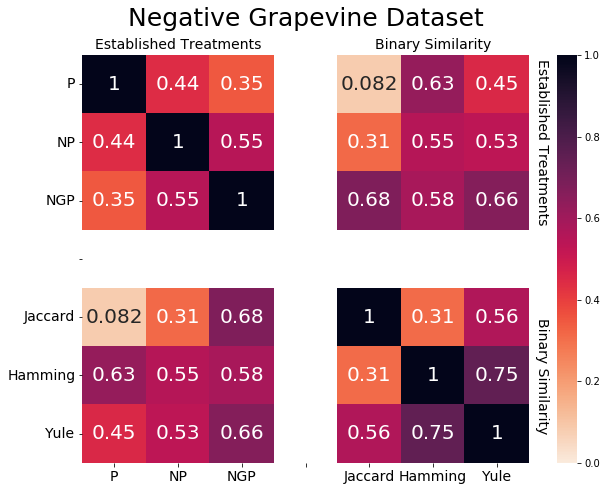

In [57]:
# Plotting the heatmap and adjusting parameters
f, ax = plt.subplots(figsize=(10, 7.5))

print("Baker's Gamma (Kendall) Correlation Coefficient Heatmap of the differently treated Negative GD")
print('Peak filtering requiring that a feature appears in at least 2 samples of all samples.')
hm = sns.heatmap(df_KI, annot=True, ax=ax, cmap = sns.cm.rocket_r, annot_kws={"size": 20}, vmin=0, vmax=1)
bottom, top = ax.get_ylim()
pos, textvals = plt.yticks()
plt.yticks(np.arange(7)+0.5,(textvals), rotation=0, fontsize="10", va="center")
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(1.5,-0.1,'Established Treatments', fontsize  = 14, horizontalalignment='center')
plt.text(7.1,1.5,'Established Treatments', fontsize  = 14, rotation = 270, verticalalignment='center')
plt.text(5.5,-0.1,'Binary Similarity', fontsize = 14, horizontalalignment='center')
plt.text(7.1,5.5,'Binary Similarity', fontsize  = 14, rotation = 270, verticalalignment='center')
plt.text(3.5,-0.5,'Negative Grapevine Dataset', fontsize  = 25, horizontalalignment='center')
ax.tick_params(labelsize= 14)
#plt.savefig('Heatmap-GD-BG-N')
plt.show()


Cophenetic Correlation Coefficient Heatmap of the differently treated Negative GD
Peak filtering requiring that a feature appears in at least 2 samples of all samples.


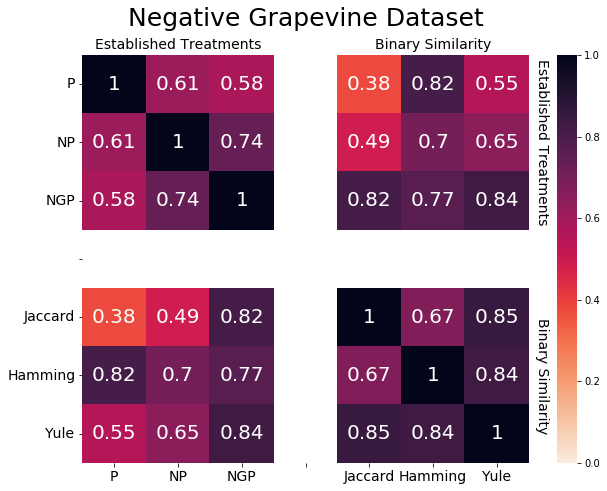

In [58]:
# Plotting the heatmap and adjusting parameters
f, ax = plt.subplots(figsize=(10, 7.5))

print("Cophenetic Correlation Coefficient Heatmap of the differently treated Negative GD")
print('Peak filtering requiring that a feature appears in at least 2 samples of all samples.')
hm = sns.heatmap(df_CI, annot=True, ax=ax, cmap = sns.cm.rocket_r, annot_kws={"size": 20}, vmin=0, vmax=1)
bottom, top = ax.get_ylim()
pos, textvals = plt.yticks()
plt.yticks(np.arange(7)+0.5,(textvals), rotation=0, fontsize="10", va="center")
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(1.5,-0.1,'Established Treatments', fontsize  = 14, horizontalalignment='center')
plt.text(7.1,1.5,'Established Treatments', fontsize  = 14, rotation = 270, verticalalignment='center')
plt.text(5.5,-0.1,'Binary Similarity', fontsize = 14, horizontalalignment='center')
plt.text(7.1,5.5,'Binary Similarity', fontsize  = 14, rotation = 270, verticalalignment='center')
plt.text(3.5,-0.5,'Negative Grapevine Dataset', fontsize  = 25, horizontalalignment='center')
ax.tick_params(labelsize= 14)

#plt.savefig('Heatmap-GD-CC-N')
plt.show()

### Positive GD (1st Filtering/Alignment) with 3 different binary distance metrics - Part of Suppl. Fig. 6.3

In [59]:
# Creation of a list with all the "rank" values (in order) for the different metrics: 
# Positive GD 1-2, 3 combination of traditional pre-treatments (Euclidian Distance) + 
# 3 different binary distance metrics (for BinSim treated datasets)
S = S_BG[3:6] + list((S_pos[2],) + (S_pos[1],) + (S_pos[6],))

#Creation of a list with all the returns from the function cophenetic for the different metrics: 
# Positive GD 1-2, 3 combination of traditional pre-treatments (Euclidian Distance) + 
# 3 different binary distance metrics (for BinSim treated datasets)
Coph = Coph_C[3:6] + list((Coph_pos[2],) + (Coph_pos[1],) + (Coph_pos[6],))

Creation of all dataframes needed to store all correlation coeficients and respective p-values fot all three methods

In [60]:
# Column names and row names for the dataframes and heatmaps

# 3 binary metrics
colnames = ['P', 'NP', 'NGP','Jaccard' , 'Hamming', 'Yule']

In [61]:
nS = len(S)
correlations = {key: np.zeros((nS,nS)) for key in ('K', 'S', 'C', 'K_p', 'S_p', 'C_p')}

# Calculation of correlation coefficient for each method
for i in range(nS):
    for j in range(nS):
        Si, Sj = S[i],S[j]
        # K - Kendall (Baker's Gamma)
        ktau = stats.kendalltau(Si,Sj)
        correlations['K'][i,j], correlations['K_p'][i,j] = ktau
        # S - Spearman (Baker's Gamma)
        spearmanr = stats.stats.spearmanr(Si,Sj)
        correlations['S'][i,j], correlations['S_p'][i,j] = spearmanr
        # C - Cophenetic Correlation
        coph = stats.pearsonr(Coph[i][1],Coph[j][1])
        correlations['C'][i,j], correlations['C_p'][i,j] = coph

for k in correlations:
    correlations[k] = pd.DataFrame(correlations[k], columns=colnames, index=colnames)

In [62]:
# Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,nS))* np.nan, columns=colnames, index=[''])
lineV = pd.concat([line.iloc[:,:3], pd.DataFrame(np.empty((1,1))* np.nan, columns =[''], index = ['']), 
                   line.iloc[:,3:]], axis = 1)

def prepare_corr_df(df):
    prep = pd.concat([df.iloc[:3], line, df.iloc[3:]])
    prep = pd.concat([prep.iloc[:,:3], lineV.T, prep.iloc[:,3:]], axis = 1)
    return prep

df_KI = prepare_corr_df(correlations['K'])
df_SI = prepare_corr_df(correlations['S'])
df_CI = prepare_corr_df(correlations['C'])

#### Heatmaps of the correlation coeficients for the 2 metrics

Baker's Gamma (Kendall) Correlation Coefficient Heatmap of the differently treated Positive GD
Peak filtering requiring that a feature appears in at least 2 samples of all samples.


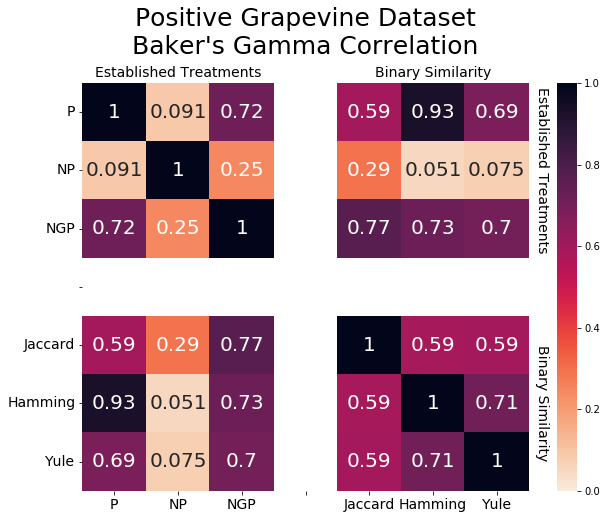

In [63]:
# Plotting the heatmap and adjusting parameters
f, ax = plt.subplots(figsize=(10, 7.5))

print("Baker's Gamma (Kendall) Correlation Coefficient Heatmap of the differently treated Positive GD")
print('Peak filtering requiring that a feature appears in at least 2 samples of all samples.')
hm = sns.heatmap(df_KI, annot=True, ax=ax, cmap = sns.cm.rocket_r, annot_kws={"size": 20}, vmin=0, vmax=1)
bottom, top = ax.get_ylim()
pos, textvals = plt.yticks()
plt.yticks(np.arange(7)+0.5,(textvals), rotation=0, fontsize="10", va="center")
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(1.5,-0.1,'Established Treatments', fontsize  = 14, horizontalalignment='center')
plt.text(7.1,1.5,'Established Treatments', fontsize  = 14, rotation = 270, verticalalignment='center')
plt.text(5.5,-0.1,'Binary Similarity', fontsize = 14, horizontalalignment='center')
plt.text(7.1,5.5,'Binary Similarity', fontsize  = 14, rotation = 270, verticalalignment='center')
plt.text(3.5,-0.5,"Positive Grapevine Dataset\nBaker's Gamma Correlation", fontsize  = 25, horizontalalignment='center')
ax.tick_params(labelsize= 14)

#plt.savefig('Heatmap-GD-BG-P')
plt.show()

Cophenetic Correlation Coefficient Heatmap of the differently treated Positive GD
Peak filtering requiring that a feature appears in at least 2 samples of all samples.


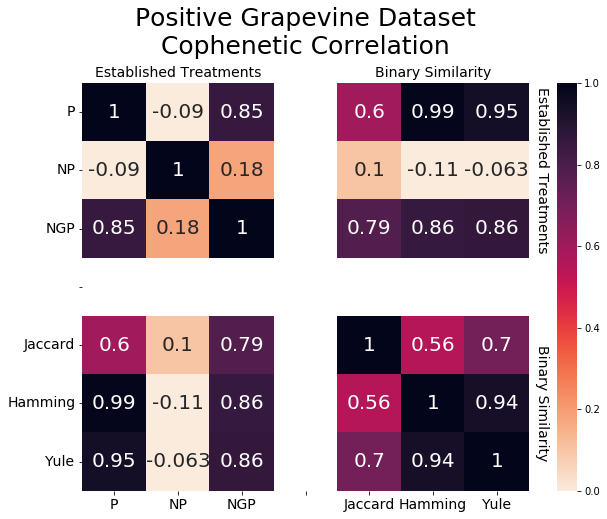

In [64]:
# Plotting the heatmap and adjusting parameters
f, ax = plt.subplots(figsize=(10, 7.5))

print("Cophenetic Correlation Coefficient Heatmap of the differently treated Positive GD")
print('Peak filtering requiring that a feature appears in at least 2 samples of all samples.')
hm = sns.heatmap(df_CI, annot=True, ax=ax, cmap = sns.cm.rocket_r, annot_kws={"size": 20}, vmin=0, vmax=1)
bottom, top = ax.get_ylim()
pos, textvals = plt.yticks()
plt.yticks(np.arange(7)+0.5,(textvals), rotation=0, fontsize="10", va="center")
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(1.5,-0.1,'Established Treatments', fontsize  = 14, horizontalalignment='center')
plt.text(7.1,1.5,'Established Treatments', fontsize  = 14, rotation = 270, verticalalignment='center')
plt.text(5.5,-0.1,'Binary Similarity', fontsize = 14, horizontalalignment='center')
plt.text(7.1,5.5,'Binary Similarity', fontsize  = 14, rotation = 270, verticalalignment='center')
plt.text(3.5,-0.5,'Positive Grapevine Dataset\nCophenetic Correlation', fontsize  = 25, horizontalalignment='center')
ax.tick_params(labelsize= 14)

#plt.savefig('Heatmap-GD-CC-P')
plt.show()

### Negative and Positive GD (1st Filtering/Alignment) with 9 different binary distance metrics - Example

In [65]:
# Creation of a list with all the "rank" values (in order) for the different metrics: 
S = S_BG[:6] + S_neg + S_pos

#Creation of a list with all the returns from the function cophenetic for the different metrics: 
Coph = Coph_C[:6] + Coph_neg + Coph_pos

Creation of all dataframes needed to store all correlation coeficients and respective p-values fot all three methods

In [66]:
# Column names and row names for the dataframes and heatmaps

# 3 binary metrics
colnames = ['P', 'NP', 'NGP','Jaccard' , 'Hamming', 'Yule']

In [67]:
# Column names and row names for the dataframes
# 3 binary metrics
#colnames = ['P_neg2_1', 'NP_neg2_1', 'NGP_neg2_1', 'P_pos2_1', 'NP_pos2_1', 'NGP_pos2_1',
            #'P_neg1_2', 'NP_neg1_2', 'NGP_neg1_2', 'P_pos1_2', 'NP_pos1_2', 'NGP_pos1_2',
#            'hamming_neg2_1', 'jaccard_neg2_1', 'yule_neg2_1',  'hamming_pos2_1', 'jaccard_pos2_1', 'yule_pos2_1']

# 9 binary metrics
colnames = ['P_neg', 'NP_neg', 'NGP_neg', 'P_pos', 'NP_pos', 'NGP_pos','dice_neg', 'hamming_neg',
            'jaccard_neg', 'rogerstanimoto_neg', 'sokalmichener_neg', 'sokalsneath_neg','yule_neg', 
            'kulsinski_neg', 'russellrao_neg','dice_pos', 'hamming_pos', 'jaccard_pos', 'rogerstanimoto_pos', 
            'sokalmichener_pos', 'sokalsneath_pos', 'yule_pos', 'kulsinski_pos', 'russellrao_pos']

In [68]:
nS = len(S)
correlations = {key: np.zeros((nS,nS)) for key in ('K', 'S', 'C', 'K_p', 'S_p', 'C_p')}

# Calculation of correlation coefficient for each method
for i in range(nS):
    for j in range(nS):
        Si, Sj = S[i],S[j]
        # K - Kendall (Baker's Gamma)
        ktau = stats.kendalltau(Si,Sj)
        correlations['K'][i,j], correlations['K_p'][i,j] = ktau
        # S - Spearman (Baker's Gamma)
        spearmanr = stats.stats.spearmanr(Si,Sj)
        correlations['S'][i,j], correlations['S_p'][i,j] = spearmanr
        # C - Cophenetic Correlation
        coph = stats.pearsonr(Coph[i][1],Coph[j][1])
        correlations['C'][i,j], correlations['C_p'][i,j] = coph

for k in correlations:
    correlations[k] = pd.DataFrame(correlations[k], columns=colnames, index=colnames)

In [69]:
# Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,nS))* np.nan, columns=colnames, index=[''])
lineV = pd.concat([line.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, columns =[''], index = ['']), 
                   line.iloc[:,6:]], axis = 1)

def prepare_corr_df(df):
    prep = pd.concat([df.iloc[:6], line, df.iloc[6:]])
    prep = pd.concat([prep.iloc[:,:6], lineV.T, prep.iloc[:,6:]], axis = 1)
    return prep

df_KI = prepare_corr_df(correlations['K'])
df_SI = prepare_corr_df(correlations['S'])
df_CI = prepare_corr_df(correlations['C'])

Baker's (Kendall) Gamma Correlation Coefficient Heatmap of the differently treated Negative andPositive GD
Peak filtering requiring that a feature appears in at least 2 samples of all samples.


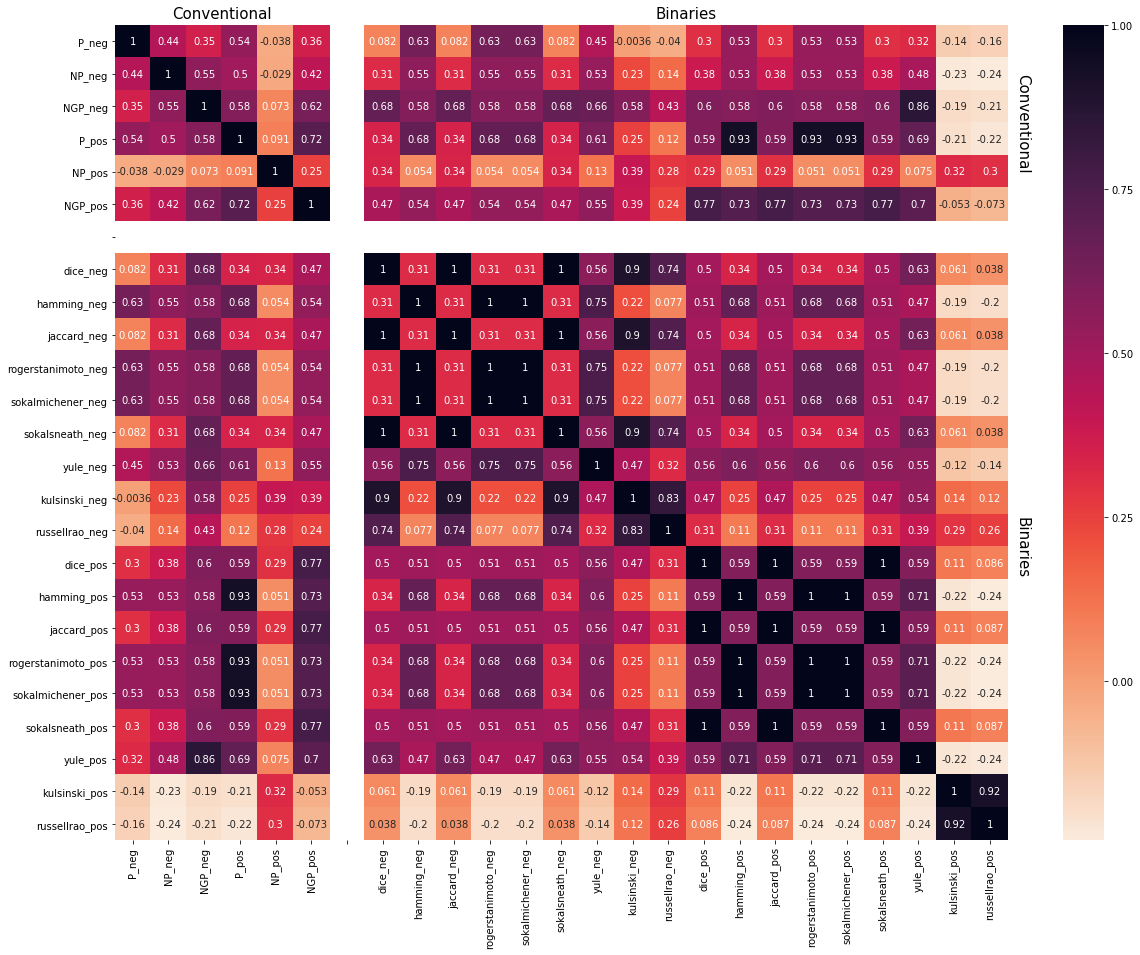

In [70]:
# Plotting the heatmap and adjusting parameters
f, ax = plt.subplots(figsize=(20, 15))

print("Baker's (Kendall) Gamma Correlation Coefficient Heatmap of the differently treated Negative andPositive GD")
print('Peak filtering requiring that a feature appears in at least 2 samples of all samples.')
hm = sns.heatmap(df_KI, annot=True, ax=ax, cmap = sns.cm.rocket_r) #cmap='YlGnBu'
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(3,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(25.2,3,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(16,-0.2,'Binaries', fontsize = 15, horizontalalignment='center') #16
plt.text(25.2,16,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center') #16

plt.show()

Cophenetic Correlation Coefficient Heatmap of the differently treated Negative andPositive GD
Peak filtering requiring that a feature appears in at least 2 samples of all samples.


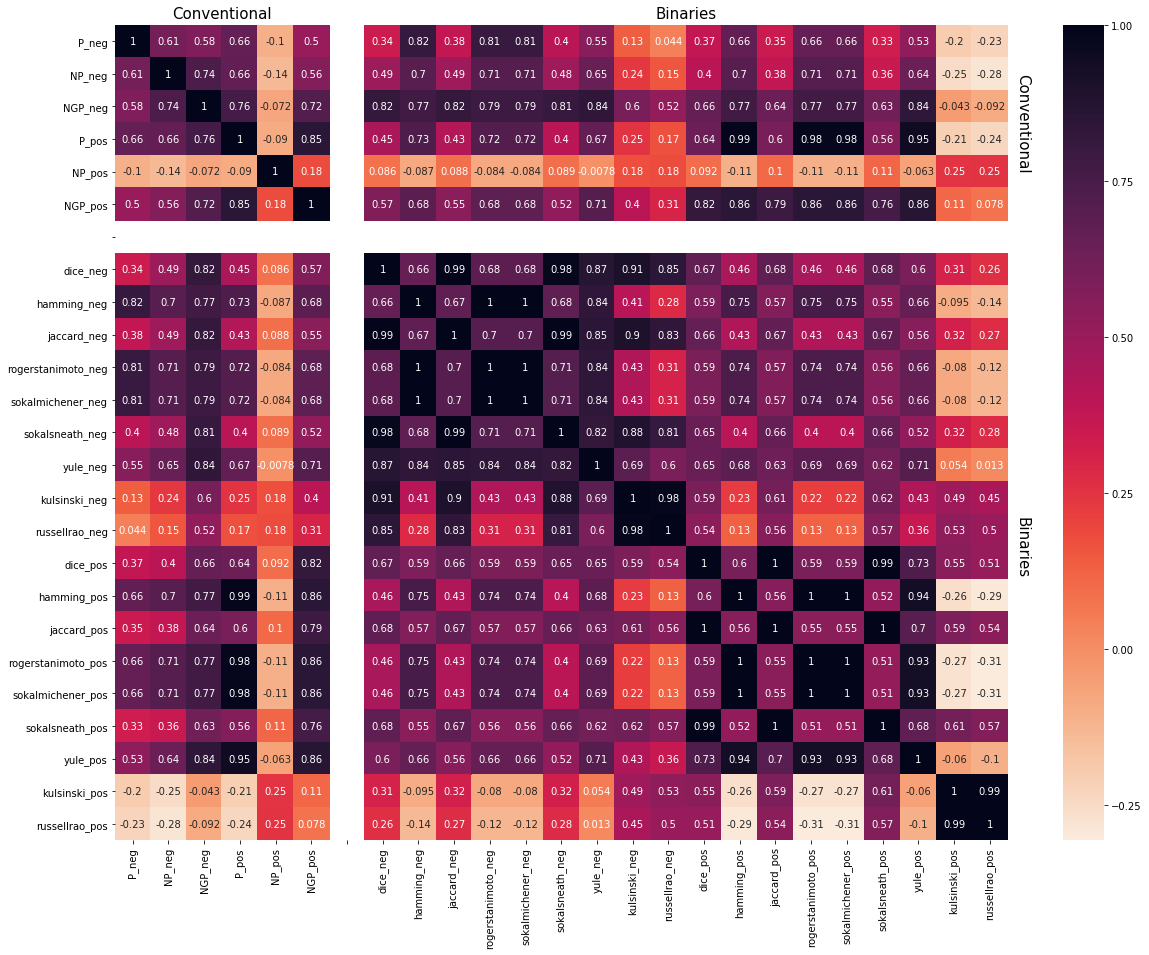

In [71]:
# Plotting the heatmap and adjusting parameters
f, ax = plt.subplots(figsize=(20, 15))

print("Cophenetic Correlation Coefficient Heatmap of the differently treated Negative andPositive GD")
print('Peak filtering requiring that a feature appears in at least 2 samples of all samples.')
hm = sns.heatmap(df_CI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(3,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(25.2,3,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(16,-0.2,'Binaries', fontsize = 15, horizontalalignment='center') #16
plt.text(25.2,16,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center') #16

plt.show()

### Hierarchical clustering of the correlation coeficients of dendrograms made with different distance metrics with each other - Not used in the end

Different colours for the Negative GD treated traditionally, Positive GD treated traditionally, Negative GD treated with BinSim (different binary distance metrics) and Positive GD treated with BinSim (different binary distance metrics).

In [72]:
label_colors2 = {}
colours2 = cm.get_cmap('nipy_spectral', 6)
col_lbl2 = colours2(range(6))
for i in range(2):
    label_colors2[colnames[3*i]] = col_lbl2[i]
    label_colors2[colnames[3*i+1]] = col_lbl2[i]
    label_colors2[colnames[3*i+2]] = col_lbl2[i]
for i in range(9):
    label_colors2[colnames[6+i]] = col_lbl2[4]
    label_colors2[colnames[15+i]] = col_lbl2[5]

HCA of the Baker's Gamma (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: Data Pre-treatment or Binary Distance Metric _ Negative or Positive Mode


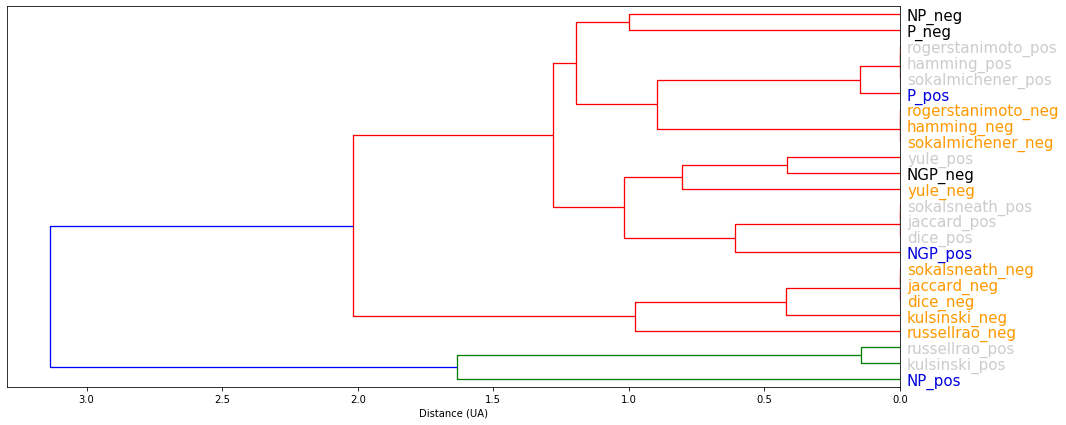

In [73]:
print("HCA of the Baker's Gamma (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics")
print('Name Convention: Data Pre-treatment or Binary Distance Metric _ Negative or Positive Mode')
Z_K = hier.linkage(correlations['K'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_K, labels=colnames,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
# Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

HCA of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: Data Pre-treatment or Binary Distance Metric _ Negative or Positive Mode


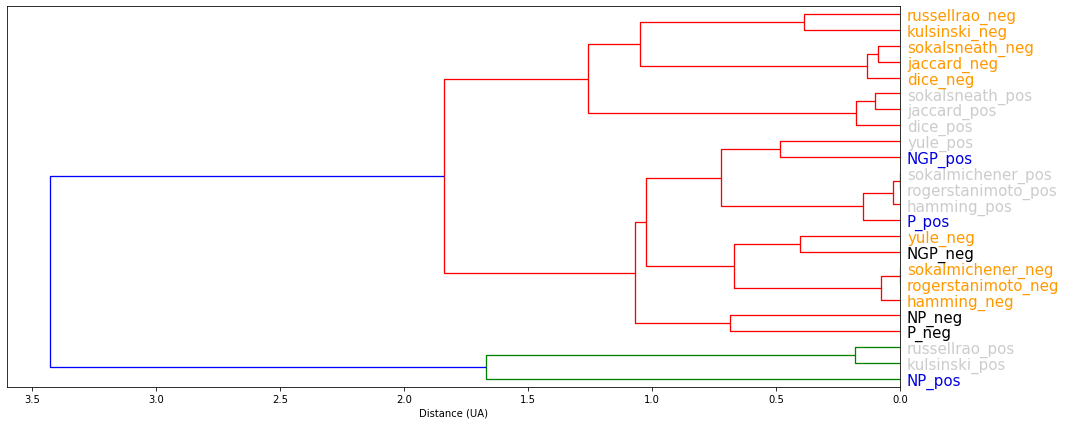

In [74]:
print('HCA of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: Data Pre-treatment or Binary Distance Metric _ Negative or Positive Mode')
Z_C = hier.linkage(correlations['C'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_C, labels=colnames,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

### Comparing HCAs (Dendrograms) Discrimination - Info for Table 3.1 and Suppl. Table 6.1

Only for 1st alignment/filtering - 1-2

Using 3 different metrics explained in the dissertation:

- Discrimination Distance
- Correct Clustering Percentage
- Correct First Cluster

Functions applied here (`dist_discrim` and `correct_1stcluster_fraction`) from multianalysis.py file of this repository with explanations of each step to calculate the different metrics.

Correct (Group) Clustering definition - samples of a group all clustered together before any other sample clustered with a sample of said group.

In [75]:
# Linkage Matrices of the different dendrograms built from the each differently-treated datasets
Z = []
Z.extend(Est_Treat_Z[:6])
Z.extend(Z_neg)
Z.extend(Z_pos)

In [76]:
disc_average = np.zeros((1,24)) # Discrimination Distance Storing
disc_correct = np.zeros((1,24)) # Correct Clustering Percentage Storing
disc_1stclust = np.zeros((1,24)) # Correct First Cluster Percentage Storing

for i in range(len(Z)):
    data = aligned_all_neg
    
    # Discrimination Distance and Correct Clustering Percentage
    discrim = ma.dist_discrim(data, Z[i], method = 'average')  # all samples have the same order
    disc_average[0,i] = discrim[0]
    #disc_median[0,i] = ma.dist_discrim(data, Z[i], 'median')[0] # all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])
    
    # Correct First Cluster Percentage
    disc_1stclust[0,i] = ma.correct_1stcluster_fraction(data, Z[i]) # all samples have the same order
    
# Transforming results into DataFrames    
disc_average = pd.DataFrame(disc_average, index = ['Discrimination Distance'], columns = colnames)
disc_correct = pd.DataFrame(disc_correct * 100 / 11, index = ['% correct groupings'], columns = colnames) # Transforming into %s
disc_1stclust = pd.DataFrame(disc_1stclust * 100, index = ['% correct 1st cluster'], columns = colnames) # Transforming into %s

# Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['Discrimination Distance']).T, disc_average.iloc[:,6:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['% correct groupings']).T, disc_correct.iloc[:,6:]], axis = 1)
disc_1stclust = pd.concat([disc_1stclust.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['% correct 1st cluster']).T, disc_1stclust.iloc[:,6:]], axis = 1)

#### Representation of the results from the three metrics with heatmaps - Info for part of Table 3.1 and Suppl. Table 6.1

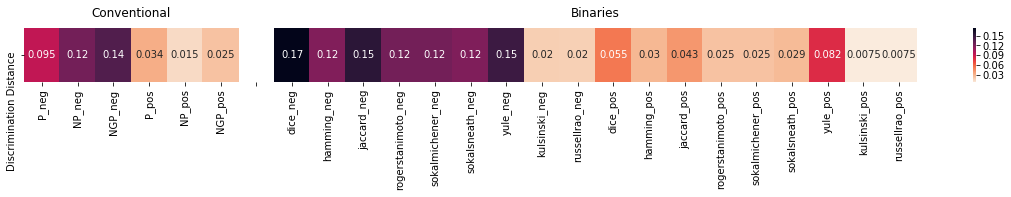

In [77]:
# Discrimination Distance
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.text(3,-0.2,'Conventional', fontsize  = 12, horizontalalignment='center')
plt.text(16,-0.2,'Binaries', fontsize = 12, horizontalalignment='center')
plt.show()

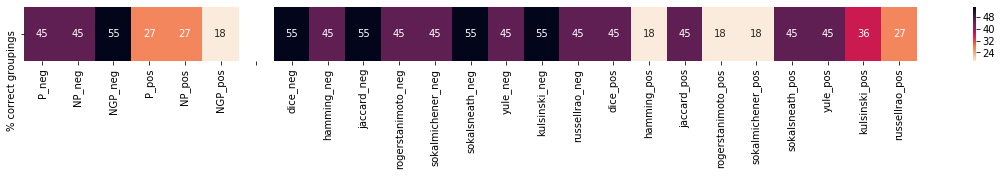

In [78]:
# Correct Clustering Percentage
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

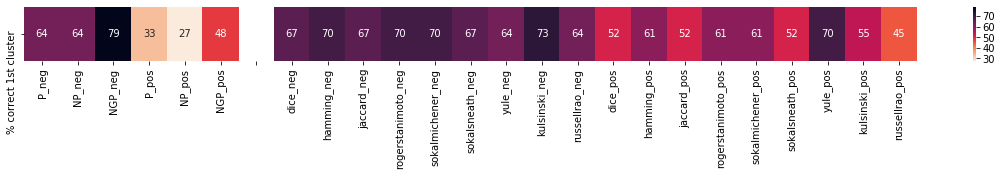

In [79]:
# Correct First Cluster Percentage
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_1stclust, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### K-means Clustering Analysis

K-means clustering analysis was applied by using the appropriate functions of the scikit-learn as done in the following cells.

In [80]:
import sklearn.cluster as skclust

#### Example of what happens in a K-means clustering analysis and how samples are separated 

Use of the sci-kit learn Python package - sklearn. 

Cluster number equal to the amount of groups. Default parameters except number of clusters.

K-means clustering analysis has an intrinsically random side to it depending on the starting position of the clusters and existence of local minima.

In [81]:
# Setting the K-means Clustering
Kmean = skclust.KMeans(n_clusters=11)

In [82]:
# Fitting the K-means clustering analysis to a dataset
a = Kmean.fit(NGP_neg.T)
a.inertia_ # Results of the function to be minimized by the K-means algorithm
# sum of squared distances of the samples to the cluster centers

44905.214215721215

In [83]:
# Example of the cluster mades with the K-means clustering analysis. Samples identified by their groups
dicto = {}

for i, lbl in enumerate(a.labels_):
    dicto.setdefault(lbl, []).append(all_labels[i])
dicto

{7: ['CAN', 'CAN'],
 1: ['CAN', 'LAB', 'LAB', 'LAB', 'SYL', 'SYL', 'SYL'],
 5: ['CS', 'CS', 'CS', 'RL', 'RL', 'RL'],
 0: ['PN', 'PN', 'PN'],
 2: ['REG', 'REG', 'REG'],
 9: ['RIP', 'RIP', 'RIP'],
 3: ['ROT', 'ROT', 'ROT'],
 6: ['RU', 'RU'],
 4: ['RU', 'TRI'],
 8: ['TRI'],
 10: ['TRI']}

Adjusted Rand Index

In [84]:
from sklearn.metrics import adjusted_rand_score
a.labels_
NGP_neg.cdl.labels
adjusted_rand_score(NGP_neg.cdl.labels,a.labels_)

0.5877616747181964

### K-means clustering applied to all euclidean methods and the binary matrixes built

Using 3 different metrics explained in the dissertation:

- Discrimination Distance (for K-means clustering)
- Correct Clustering Percentage (for K-means clustering)
- Adjusted Rand Index (calculated by scikit-learn - `adjusted_rand_index`)

Due to the randomness of the K-means clustering analysis (position of initial cluster centers leading to different local minima), this analysis was iterated 150 times and the 10% of analysis that led to a greater minimization of the objective function - sum of squared distances of the samples to the cluster centers - were chosen to calculate the 3 different metrics mentioned. The Median of the different metrics were taken as the final results.

`Kmeans_discrim` function applied here from multianalysis.py file of this repository with explanations of each step to calculate the different metrics.

Correct clustering definition - K-means Cluster contains all and only the samples of a single group (stricter definition than in HCA).

A method similar to the Discrimination Distance and Correct Clustering percentage performed in the HCA was made. Replicates of a variety can be together in a cluster but, if there are more samples in the same cluster, its "discrimination distance" is still zero and the groups isn't correctly clustered. Therefore, this method is harsher than the Discrimination Distance and Correct Clustering Percentage for HCA.  Thus, the Correct Clustering Percentage is expected to be lower in this case

The Discrimination Distance is calculated as the distance between the centroid of the cluster where the samples are and the closest centroid. It is normalized by dividing it by the maximum distance between any 2 centroids of the clusters formed. The mean of the Discrimination Distances of all groups is then a measure of the global Discrimination Distance. 

In [85]:
colnames2 = ['P_neg1_2', 'NP_neg1_2', 'NGP_neg1_2', 'P_pos1_2', 'NP_pos1_2', 'NGP_pos1_2',
             'P_neg2_1', 'NP_neg2_1', 'NGP_neg2_1', 'P_pos2_1', 'NP_pos2_1', 'NGP_pos2_1',
             'BinSim_neg1_2', 'BinSim_pos1_2','BinSim_neg2_1', 'BinSim_pos2_1']

In [86]:
Data = (P_neg, NP_neg, NGP_neg, P_pos, NP_pos, NGP_pos,
        P_neg2, NP_neg2, NGP_neg2, P_pos2, NP_pos2, NGP_pos2, 
        bin_neg, bin_pos, bin_neg2, bin_pos2)

In [87]:
disc_average = np.zeros((1,16)) # Discrimination Distance
disc_correct = np.zeros((1,16)) # Correct Clustering Percentage
disc_rand = np.zeros((1,16)) # Adjusted Rand Index

for i in range(len(Data)):
    # Applying Kmeans_discrim function 150 times, taking the best 10% and measuring the Discrimination Distance, Correct
    # Clustering percentage and adjusted Rand Index metrics to evaluate the discrimination.
    discrim = ma.Kmeans_discrim(Data[i], method = 'average', iter_num=150, best_fraction=0.1)
    
    # Lists for the results of the best k-means clustering
    average = []
    correct = []
    rand = []
    for j in discrim:
        average.append(discrim[j][0]) # Discrimination Distances
        all_correct = np.array(list(discrim[j][1].values()))
        correct.append(len(all_correct[all_correct>0])) # Correct Clustering Percentages
        rand.append(discrim[j][2]) # Adjusted Rand Index
    
    # Putting results into the arrays - median of the best k-means clustering
    disc_average[0,i] = np.median(average) 
    disc_correct[0,i] = np.median(correct)
    disc_rand[0,i] = np.median(rand)

# Transforming into DataFrame
disc_average = pd.DataFrame(disc_average, index = ['Discrimination Distance'], columns = colnames2)
disc_correct = pd.DataFrame(disc_correct * 100 /11, index = ['% correct groupings'], columns = colnames2) # Transforming into %s
disc_rand = pd.DataFrame(disc_rand, index = ['Rand Index'], columns = colnames2)

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['Discrimination Distance']).T, disc_average.iloc[:,6:12], 
                                                pd.DataFrame(np.empty((1,1))* np.nan, index = [''], columns = 
                                                ['Discrimination Distance']).T, disc_average.iloc[:,12:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['% correct groupings']).T, disc_correct.iloc[:,6:12], 
                                                pd.DataFrame(np.empty((1,1))* np.nan, index = [''], columns = 
                                                ['% correct groupings']).T, disc_correct.iloc[:,12:]], axis = 1)
disc_rand = pd.concat([disc_rand.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['Rand Index']).T, disc_rand.iloc[:,6:12], 
                                                pd.DataFrame(np.empty((1,1))* np.nan, index = [''], columns = 
                                                ['Rand Index']).T, disc_rand.iloc[:,12:]], axis = 1)

#### K-means Clustering Analysis Results - Info for Table 3.2 and Suppl. Table 6.2

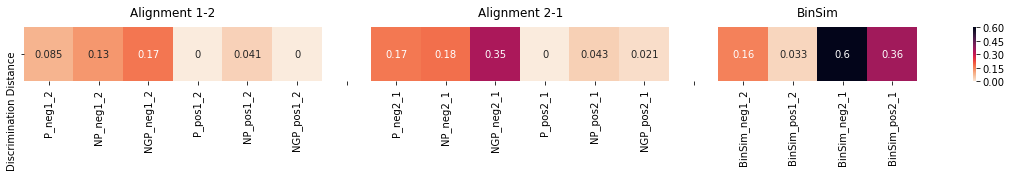

In [88]:
# Discrimination Distance
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.text(3,-0.2,'Alignment 1-2', fontsize  = 12, horizontalalignment='center')
plt.text(10,-0.2,'Alignment 2-1', fontsize  = 12, horizontalalignment='center')
plt.text(16,-0.2,'BinSim', fontsize = 12, horizontalalignment='center')
plt.show()

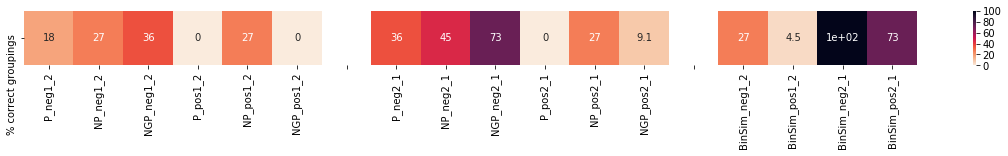

In [89]:
# Correct Clustering Percentage
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

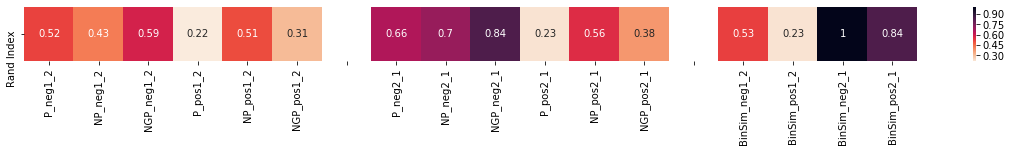

In [90]:
# Adjusted Rand Index
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_rand, annot=True, ax=ax, cmap = sns.cm.rocket_r)

## Supervised Statistical Analysis

### From now on, results will only be shown for Alignment/Filtering 1-2 (used in the dissertation)

The Supervised Statistical Analysis methods used will be Random Forest and PLS-DA. The performance of the models/classifiers built will be evaluated by their predictive accuracy (which will always be estimated by internal stratified 3-fold cross-validation).

Internal stratified 3-fold cross-validation was used to estimate the model's performance since that is maximum number possible since every group of samples only has 3 replicates in the dataset.

The datasets that will be analyzed (differently-treated Negative and Positive GD (1-2)):

In [91]:
# Centralize data information in a dictionary
datasets = {}

datasets['P_neg'] = treat_neg['P']
datasets['NP_neg'] = treat_neg['NP']
datasets['NGP_neg'] = treat_neg['NGP']
datasets['BinSim_neg'] = treat_neg['binary']

datasets['P_pos'] = treat_pos['P']
datasets['NP_pos'] = treat_pos['NP']
datasets['NGP_pos'] = treat_pos['NGP']
datasets['BinSim_pos'] = treat_pos['binary']

##### Change these datasets if you want to analyze the other Alignment/Filtering

## Random Forests

### Test number of trees needed for predictive accuracy convergence for P, NP, NGP and BinSim treated data

Random Forest models with different number of trees will be built to assess when the predictive accuracy of the different models stops increasing with higher number of trees.

Grid search of number of trees from 10 to 200 for the random forests. See where the cross-validation estimated predictive accuracy stops improving for each one.

#### Takes  some time

In [92]:
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble
#Vector with values for the parameter n_estimators
values = {'n_estimators': range(10,400,2)} # Models will be built from 10 to 200 trees in 2 tree intervals

rf = skensemble.RandomForestClassifier(n_estimators = 200)
clf = GridSearchCV(rf, values, cv =3)

In [93]:
# For each dataset,building the Random Forest models with the different number of trees
# and storing the predictive accuracy (estimated by 3-fold cross-validation)
param = []
test_score = []
for name, dataset in datasets.items():
    print('Fitting', name, '...', end=' ')
    clf.fit(dataset.T, all_labels)
    param.append(clf.cv_results_['param_n_estimators'])
    test_score.append(clf.cv_results_['mean_test_score'])
    print('Done!')

Fitting P_neg ... Done!
Fitting NP_neg ... Done!
Fitting NGP_neg ... Done!
Fitting BinSim_neg ... Done!
Fitting P_pos ... Done!
Fitting NP_pos ... Done!
Fitting NGP_pos ... Done!
Fitting BinSim_pos ... Done!


#### Part of Fig. 3.3 - Negative Grapevine Dataset

Performance (Predictive Accuracy) based on number of trees - Negative Grapevine Dataset


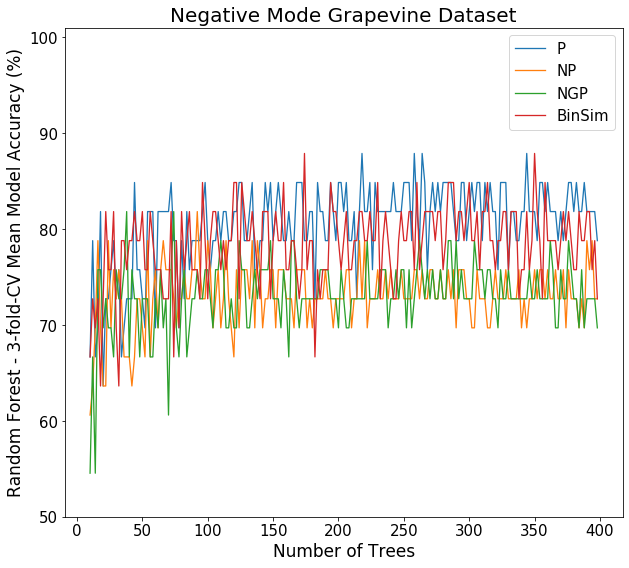

In [94]:
# Plotting the results and adjusting parameters of the plot
f, ax = plt.subplots(figsize=(10,9))

for i in range(4):
    plt.plot(param[i], test_score[i]*100)

plt.ylabel('Random Forest - 3-fold-CV Mean Model Accuracy (%)', fontsize = 17)
plt.xlabel('Number of Trees', fontsize = 17)
ax.legend(('P', 'NP', 'NGP', 'BinSim'), fontsize=15)
plt.ylim(50,101)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.title('Negative Mode Grapevine Dataset', fontsize=20)
print('Performance (Predictive Accuracy) based on number of trees - Negative Grapevine Dataset')

#### Part of Suppl. Fig. 6.4 - Positive Grapevine Dataset

Performance based on number of trees - Alignment: 1-2, Positive Mode


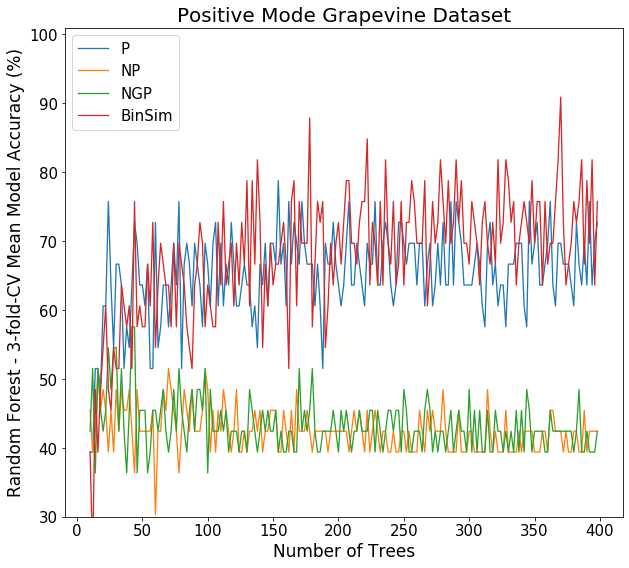

In [95]:
# Plotting the results and adjusting parameters of the plot
f, ax = plt.subplots(figsize=(10,9))

for i in range(4,8):
    plt.plot(param[i], test_score[i]*100)

plt.ylabel('Random Forest - 3-fold-CV Mean Model Accuracy (%)', fontsize = 17)
plt.xlabel('Number of Trees', fontsize = 17)
ax.legend(('P', 'NP', 'NGP', 'BinSim'), fontsize=15)
plt.ylim(30,101)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.title('Positive Mode Grapevine Dataset', fontsize=20)
print('Performance based on number of trees - Alignment: 1-2, Positive Mode')

### Random Forest Application

Stores predictive accuracy of the models, standard deviation of the predictive accuracy (across the iterations) and an ordered list of the most to least important features (average across the iterations) in building the model according to the Gini Importance calculated by scikit-learn (all estimated by stratified 3-fold cross-validation) of each of the 200 iterations (with different samplings of the 3 folds) of models built for each secondary dataset.

Iterations are made to randomly sample the folds in 3-fold cross-validation - more combinations of training and test samples are used to offset the small (in terms of samples per group) dataset.

Use of the `simple_RF` function of multianalysis.py (uses Random Forest algorithm from scikit-learn) where each step of the process is better explained.

In [96]:
# Preparations of dicts:
Scores = {} # Stores Predictive Accuracy
Scores_std = {} # Stores Predictive Accuracy's Standard Deviation
Imp_feat = {} # Stores ordered list of most to least important feature to build the model

In [97]:
# Application of the Random Forests for each differently-treated dataset
for name, data in datasets.items():
    print(f'Fitting random forest for {name} ...', end='')
    rf, imp_features = ma.simple_RF(data, iter_num=200) #, iter_num = 100)
    Scores[name] = rf
    Scores_std[name] = np.std(rf)
    Imp_feat[name] = imp_features
    print(f'done')    

Fitting random forest for P_neg ...done
Fitting random forest for NP_neg ...done
Fitting random forest for NGP_neg ...done
Fitting random forest for BinSim_neg ...done
Fitting random forest for P_pos ...done
Fitting random forest for NP_pos ...done
Fitting random forest for NGP_pos ...done
Fitting random forest for BinSim_pos ...done


#### Results of the Random Forest - Performance (Predictive Accuracy) 

#### Negative Grapevine Dataset - Part of Fig. 3.5

Predictive Accuracy of Random Forest models - Negative Grapevine Dataset


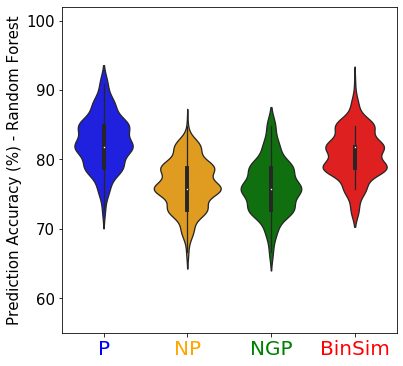

In [98]:
# Violin plot of the distribution of the predictive accuracy (in %) across 200 iterations of randomly sampled folds for each 
# differently-treated dataset and adjustments to the parameters of the plot.
f, ax = plt.subplots(figsize=(6,6))

# Select only data from the Negative Grapevine Dataset
data = pd.DataFrame.from_dict(Scores).iloc[:,:4] * 100

data.columns = ['P', 'NP', 'NGP', 'BinSim']
colors = ['blue','orange','green','red']
sns.violinplot( data = data, palette = colors, alpha = 0.5)
plt.ylabel('Prediction Accuracy (%) - Random Forest', fontsize = 15)
plt.ylim([55,102])
ax.tick_params(axis='x', which='major', labelsize = 20)
ax.tick_params(axis='y', which='major', labelsize = 15)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)
#plt.title('Yeast Dataset', fontsize = 20)
#plt.savefig('RF-NGD')
print('Predictive Accuracy of Random Forest models - Negative Grapevine Dataset')

#### Positive Grapevine Dataset - Part of Suppl. Fig. 6.6

Predictive Accuracy of Random Forest models - Positive Grapevine Dataset


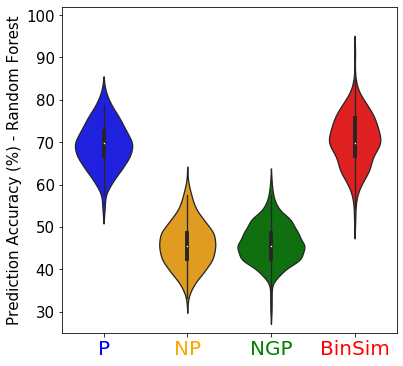

In [99]:
# Violin plot of the distribution of the predictive accuracy (in %) across 200 iterations of randomly sampled folds for each 
# differently-treated dataset and adjustments to the parameters of the plot.
f, ax = plt.subplots(figsize=(6,6))

# Select only data from the Positive Grapevine Dataset
data = pd.DataFrame.from_dict(Scores).iloc[:,4:] * 100
data.columns = ['P', 'NP', 'NGP', 'BinSim']
colors = ['blue','orange','green','red']
sns.violinplot( data = data, palette = colors, alpha = 0.5)
plt.ylabel('Prediction Accuracy (%) - Random Forest', fontsize = 15)
plt.ylim([25,102])
ax.tick_params(axis='x', which='major', labelsize = 20)
ax.tick_params(axis='y', which='major', labelsize = 15)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)
#plt.title('Yeast Dataset', fontsize = 20)
#plt.savefig('RF-NGD')
print('Predictive Accuracy of Random Forest models - Positive Grapevine Dataset')

#### Info for part of Fig. 3.5 and Suppl. Fig. 6.6

In [100]:
# Average prediction accuracy of the models built for each of the
# differently-treated datasets estimated by stratified 3-fold cross validation
Scores_A = {}
for i in Scores:
    Scores_A[i] = np.mean(Scores[i])

In [101]:
# Plotting the results
#Scores_H = pd.DataFrame(list(Scores_A.values()), index = Scores_A.keys()).T
#f, ax = plt.subplots(figsize=(10, 1))
#hm = sns.heatmap(Scores_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV'])
#plt.text(4,-0.2,'1-2', fontsize  = 12, horizontalalignment='center')
#plt.show()
Scores_A

{'P_neg': 0.8257575757575757,
 'NP_neg': 0.7634848484848484,
 'NGP_neg': 0.7610606060606061,
 'BinSim_neg': 0.8065151515151515,
 'P_pos': 0.6931818181818182,
 'NP_pos': 0.4595454545454545,
 'NGP_pos': 0.46303030303030296,
 'BinSim_pos': 0.7054545454545454}

#### Other info and images

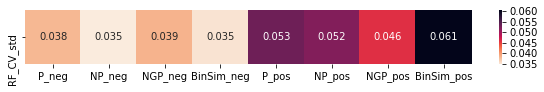

In [102]:
Scores_std_H = pd.DataFrame(list(Scores_std.values()), index = Scores.keys()).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Scores_std_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_std'])

Accuracy based on the dataset


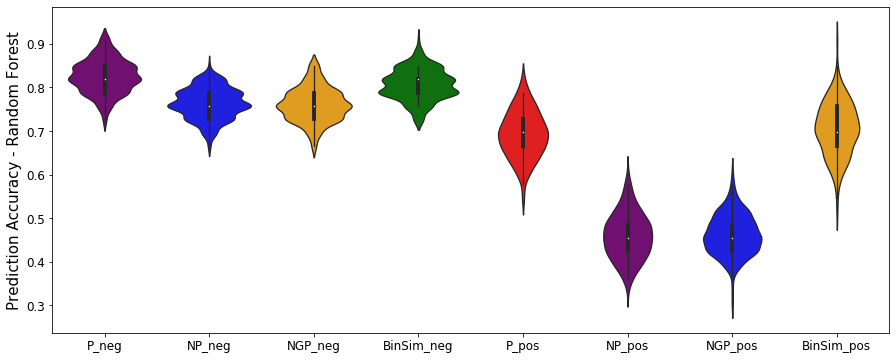

In [103]:
f, ax = plt.subplots(figsize=(15,6))
data = pd.DataFrame.from_dict(Scores)
colors = ['purple','blue','orange','green','red']
sns.violinplot( data = data, palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - Random Forest', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 12)
print('Accuracy based on the dataset')

In [104]:
Scores_H = pd.DataFrame(list(Scores_A.values()), index = Scores_A.keys(), columns = ['Accuracy']).T
#Scores_std_H = pd.DataFrame(list(Scores_std.values()), index = Scores.keys()).T
#Scores_ic = Scores_std_H / (200**0.5)*1.96

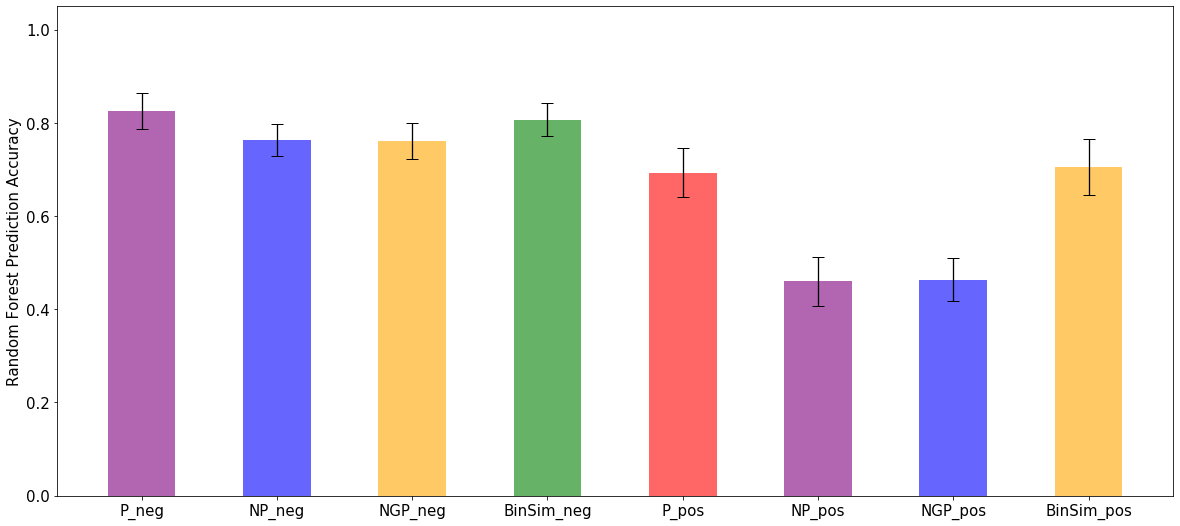

In [105]:
# Plotting bar plots with standard deviation error bars
#sns.set_context('notebook')
f, ax = plt.subplots(figsize=(20, 9))

color = ['purple','blue','orange','green','red']
plt.bar(height = Scores_H.T['Accuracy'], x = Scores_H.columns, width = 0.5, color = color, alpha = 0.6)
ax.errorbar(x = Scores_H.columns, y = Scores_H.T['Accuracy'], yerr = Scores_std_H.iloc[0,:10], 
            ls = 'none', ecolor = 'black', capsize = 6)
plt.ylim(0,1.05)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Random Forest Prediction Accuracy', fontsize = 15)
plt.show()

##### Other attempts and ways to apply Random Forest were made with different parameters and sample manipulation, they were removed for simplicity, some of the functions such as fast_SMOTE, RF_M3 and RF_M4 are still present (although not fully commented) in multianalysis.py

### Characteristics of the features considered as important in the differently-treated datasets (Negative and Positive)

We take the 2% most important features in each case and calculate the median number of samples those features appear (samples_m), the median number of different groups/varieties those features appear in (groups_n) and the ratio between these two measures (ratio_m, has a maximum of 3). 

A swarmplot is also built to see the distributions of the number of samples each important feature in each method appears to see their overall distribution.

We also see how many times the importance of the most important feature is greater than the average importance of a feature in each case ('magni') as well as the % of the model explained (that use) the 2% of the most important features ('explained').

In [106]:
# Getting the number of samples, groups, ratios for each important feature, magnitude for most important feature,
# calculating % explained by these features (explained) and identification of important features (in negative and positive GD)
ev = []
magni = []
explained = []
imp_feat_id_neg = {}
imp_feat_id_pos = {}

for name in Imp_feat:
    # Choose the respective original spectra for each differently treated dataset
    if name.endswith('neg'):
        #continue
        Spectra = aligned_all_neg
    elif name.endswith('pos'):
        #continue
        Spectra = aligned_all_pos
    #elif name.endswith('neg2'):
        #continue
        #Spectra = aligned_all_neg2
    #elif name.endswith('pos2'):
        #continue
        #Spectra = aligned_all_pos2
    
    # Important Features
    imp_features = Imp_feat[name]
    
    ratio = []
    nsamples = []
    n_groups = []
    imp_feat_id_temp = []
    
    # Top 2% (rounded)
    number = round(0.02*len(Spectra))
    magni.append(imp_features[0][1]/(1/len(Spectra))) # Calculate, store how many times feature is more important than average
    
    a = 0 # Count the % explained - add for each feature
    for i in range(number): # Iterate for only the number of features considered as important
        a = a + imp_features[i][1]*100 
        
        ngroups = {}
        line = Spectra.loc[imp_features[i][2],:].notnull() # Identify feature in Spectra
        nsamples.append(line.sum()) # Count how many samples the feature appears in
        
        # Count how many groups the feature appears in
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.cdl.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        
        # Calculate the ratio of number of samples to number of groups the feature appears in
        ratio.append(nsamples[-1]/n_groups[-1])
        
        # Store identification of feature
        imp_feat_id_temp.append(imp_features[i][2])
    
    explained.append(a) # Store % explained
    
    # Organizing info in a dataframe and store it in 'ev'
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev.append(df)
    
    # Storing important feature identification
    if name.endswith('neg'):
        imp_feat_id_neg[name] = imp_feat_id_temp
    elif name.endswith('pos'):
        imp_feat_id_pos[name] = imp_feat_id_temp
    #print(ev[4])

In [107]:
# Calculating medians of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []

# For each DataFrame in 'ev'
for i in range(len(ev)):
    # Calculate and store the median for the sample number, group number and ratio
    samples_m.append(np.median(ev[i].iloc[:,0]))
    groups_m.append(np.median(ev[i].iloc[:,1]))
    ratio_m.append(np.median(ev[i].iloc[:,2]))
    
# Organize information in a DataFrame
df = pd.DataFrame(columns = ['Sample Nº', 'Group nº', 'Ratio'], index = [i  for i in Imp_feat])
df['Sample Nº'] = samples_m
df['Group nº'] = groups_m
df['Ratio'] = ratio_m
#print(df)

# Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"Sample Nº": None, "Group nº": None, 'Ratio':None}, index=[''])
df = pd.concat([df.iloc[:4], line, df.iloc[4:8]])

#### Info for Fig. 3.6 and Suppl. Fig 6.8

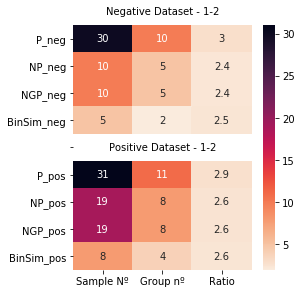

In [108]:
# Plot the results in a Heatmap (adjusting parameters)
f, ax = plt.subplots(figsize=(4, 4.5))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(1.5,-0.5,'Negative Dataset - 1-2',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,4.5,'Positive Dataset - 1-2',horizontalalignment='center', verticalalignment='center')
plt.show()

#### Negative Grapevine Dataset - Info for Fig. 3.6

Plotting swarmplots with the distributions of samples important features appear in.

Distribution of number of samples important features of Random Forest models appear in - Negative Grapevine Dataset


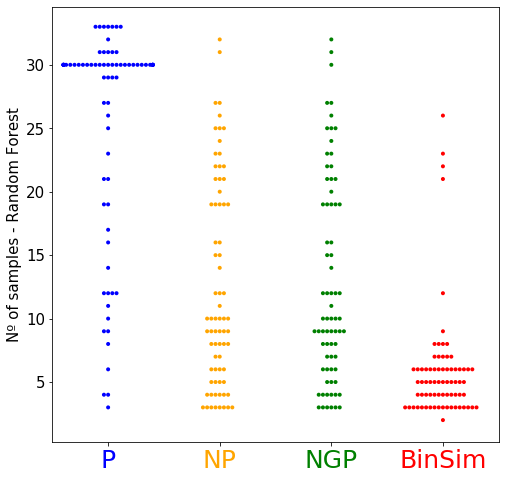

In [109]:
# Plot the swarm plot and adjust parameters
f, ax = plt.subplots(figsize=(8,8))
data = [ev[i]['nsamples'] for i in range(4)] #range(len(ev))]
#print(data)
#sns.violinplot(data=data)
sns.swarmplot(data=data, size = 4, palette = ['blue','orange','green','red'])
ax.set(xticklabels = ['P','NP','NGP','BinSim'])
ax.tick_params(axis='x', which='major', labelsize=25)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.ylabel('Nº of samples - Random Forest', fontsize = 15)
colors = ['blue','orange','green','red']
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)

print('Distribution of number of samples important features of Random Forest models appear in - Negative Grapevine Dataset')
#plt.savefig('RF-NGD-IF')
plt.show()

#### Positive Grapevine Dataset - Info for Suppl. Fig. 6.8

Distribution of number of samples important features of Random Forest models appear in - Positive Grapevine Dataset


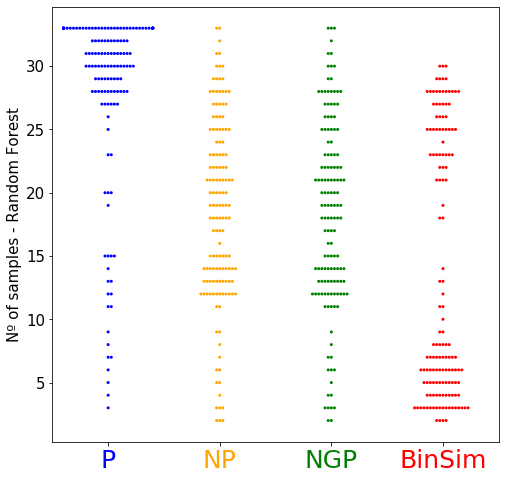

In [110]:
# Plot the swarm plot and adjust parameters
f, ax = plt.subplots(figsize=(8,8))
data = [ev[i]['nsamples'] for i in range(4,8)] #range(len(ev))]
#print(data)
#sns.violinplot(data=data)
sns.swarmplot(data=data, size = 3, palette = ['blue','orange','green','red'])
ax.set(xticklabels = ['P','NP','NGP','BinSim'])
ax.tick_params(axis='x', which='major', labelsize=25)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.ylabel('Nº of samples - Random Forest', fontsize = 15)
colors = ['blue','orange','green','red']
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)
    
print('Distribution of number of samples important features of Random Forest models appear in - Positive Grapevine Dataset')
#plt.savefig('RF-PGD-IF')
plt.show()

In [111]:
print('Magnitude of most important feature:', )
for i in range(len(Imp_feat.keys())):
    print(list(Imp_feat.keys())[i], '  \t', magni[i])
    
print('\n')
print('% of model explained by the 2% most important features')
for i in range(len(Imp_feat.keys())):
    print(list(Imp_feat.keys())[i], '   \t', explained[i])

Magnitude of most important feature:
P_neg   	 4.849140467341803
NP_neg   	 3.1640644219083955
NGP_neg   	 3.2131526495374554
BinSim_neg   	 5.934091763680271
P_pos   	 13.779981206359327
NP_pos   	 7.463978088161677
NGP_pos   	 7.230044172391481
BinSim_pos   	 9.657586324623448


% of model explained by the 2% most important features
P_neg    	 7.544322018191354
NP_neg    	 4.926319785706776
NGP_neg    	 4.919605388345829
BinSim_neg    	 7.055918004166066
P_pos    	 14.530262459480598
NP_pos    	 8.593984498937028
NGP_pos    	 8.611282001292341
BinSim_pos    	 10.897728487390593


#### Intersections of Important Features used to build each differently-treated dataset - Random Forest

#### Negative Grapevine Dataset - Information (after some calculations) for Fig 3.6

Be careful with features present in all sets, in 3 of the sets and in 2 sets for calculating values for Venn Diagram

Easier ways to obtain the results directly are available but since it is already done.

In [112]:
# Easier to write
name = imp_feat_id_neg

# How many Features are in at least one of the sets of important features of the differently-treated dataset
union = len(np.union1d(np.union1d(np.union1d(name['P_neg'],name['NP_neg']), name['NGP_neg']), name['BinSim_neg']))
print('Nº of different features across the sets of important features:', union)

# How many Features are in all sets of important features of the differently-treated dataset
intersection = len(np.intersect1d(np.intersect1d(np.intersect1d(name['P_neg'],name['NP_neg']), name['NGP_neg']),
                                  name['BinSim_neg']))
print('Nº of features present in all sets of important features:', intersection, '\n')

# Build DataFrame for pairwise intersection of the sets of important features
intersec = pd.DataFrame(np.zeros((4,4)), index=name.keys(), columns=name.keys())
for i in name.keys():
    for j in name.keys():
        intersec.loc[i,j] = len(np.intersect1d(name[i],name[j]))#/len(name[i])     
        
# Intersections of 3 of the 4 different sets of important features
for i,j,m in itertools.combinations(name,3):
    print('Sets of features considered:',i,',',j,',',m,'.',
          'Number of features in the 3 sets:', len(np.intersect1d(np.intersect1d(name[i],name[j]), name[m])))

print('\nDataframe with the intersection of two set of important features for each pairwise combination:')    
print(intersec)

Nº of different features across the sets of important features: 182
Nº of features present in all sets of important features: 4 

Sets of features considered: P_neg , NP_neg , NGP_neg . Number of features in the 3 sets: 15
Sets of features considered: P_neg , NP_neg , BinSim_neg . Number of features in the 3 sets: 4
Sets of features considered: P_neg , NGP_neg , BinSim_neg . Number of features in the 3 sets: 5
Sets of features considered: NP_neg , NGP_neg , BinSim_neg . Number of features in the 3 sets: 21

Dataframe with the intersection of two set of important features for each pairwise combination:
            P_neg  NP_neg  NGP_neg  BinSim_neg
P_neg        73.0    15.0     18.0         8.0
NP_neg       15.0    73.0     65.0        23.0
NGP_neg      18.0    65.0     73.0        22.0
BinSim_neg    8.0    23.0     22.0        73.0


#### Positive Grapevine Dataset - Information (after some calculations) for Suppl. Fig. 6.8

Be careful with features present in all sets, in 3 of the sets and in 2 sets for calculating values for Venn Diagram.

Easier ways to obtain the results directly are available but since it is already done.

In [113]:
# Easier to write
name = imp_feat_id_pos

# How many Features are in at least one of the sets of important features of the differently-treated dataset
union = len(np.union1d(np.union1d(np.union1d(name['P_pos'],name['NP_pos']), name['NGP_pos']), name['BinSim_pos']))
print('Nº of different features across the sets of important features:', union)

# How many Features are in all sets of important features of the differently-treated dataset
intersection = len(np.intersect1d(np.intersect1d(np.intersect1d(name['P_pos'],name['NP_pos']), name['NGP_pos']),
                                  name['BinSim_pos']))
print('Nº of features present in all sets of important features:', intersection, '\n')

# Build DataFrame for pairwise intersection of the sets of important features
intersec = pd.DataFrame(np.zeros((4,4)), index=name.keys(), columns=name.keys())
for i in name.keys():
    for j in name.keys():
        intersec.loc[i,j] = len(np.intersect1d(name[i],name[j]))#/len(name[i])     
        
# Intersections of 3 of the 4 different sets of important features
for i,j,m in itertools.combinations(name,3):
    print('Sets of features considered:',i,',',j,',',m,'.',
          'Number of features in the 3 sets:', len(np.intersect1d(np.intersect1d(name[i],name[j]), name[m])))

print('\nDataframe with the intersection of two set of important features for each pairwise combination:')    
print(intersec)

Nº of different features across the sets of important features: 345
Nº of features present in all sets of important features: 18 

Sets of features considered: P_pos , NP_pos , NGP_pos . Number of features in the 3 sets: 23
Sets of features considered: P_pos , NP_pos , BinSim_pos . Number of features in the 3 sets: 20
Sets of features considered: P_pos , NGP_pos , BinSim_pos . Number of features in the 3 sets: 19
Sets of features considered: NP_pos , NGP_pos , BinSim_pos . Number of features in the 3 sets: 40

Dataframe with the intersection of two set of important features for each pairwise combination:
            P_pos  NP_pos  NGP_pos  BinSim_pos
P_pos       141.0    26.0     26.0        36.0
NP_pos       26.0   141.0    126.0        45.0
NGP_pos      26.0   126.0    141.0        44.0
BinSim_pos   36.0    45.0     44.0       141.0


## PLS-DA - Classifiers

Creating the target vectors matrix where each different group is made into a column and 1 represents the sample belongs to that group (0 means it doesn't belong) with one-hot encoding.

PLS-DA models were built using the PLSRegression module of scikit-learn while imposing a decision rule where the group corresponding to the maximum value in the predicted regression vector (one value for each group) obtained for a test sample (ypred) is chosen. 

In [114]:
matrix = pd.get_dummies(all_labels)
matrix

,CAN,CS,LAB,PN,REG,RIP,RL,ROT,RU,SYL,TRI
0,1,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,0
6,0,0,1,0,0,0,0,0,0,0,0
7,0,0,1,0,0,0,0,0,0,0,0
8,0,0,1,0,0,0,0,0,0,0,0
9,0,0,0,1,0,0,0,0,0,0,0


### Optimization - Search for the best number of components to use - Part of Fig. 3.4 and Suppl. Fig 6.5

The number of components were optimized by observing the score metric of the PLSRegression of scikit learn, that is, the 1 - PRESS/SS or Q2 of models built with 1 to n components.

PRESS - Predictive Residual Sum of Squares
SS - residual Sum of Squares

Strategy: Perform PLS-DA with different number of components and observe the score (given directly by the method score, inverse relation to the mean-squared error (MSE)) of the models built estimated with stratified 3-fold cross-validation. Then plot the different results obtained and see at which point (number of components) the score starts approaching a "stable maximum value".

To observe details of the `optim_PLS` function - performs PLS analysis and obtains the results stated above with number of components defined from 1 to max_comp - see multianalysis.py file. 

These regression metrics are not suitable to evaluate the performance of the classifier, they were just used to optimize the number of components to build the final PLS-DA models.

In [115]:
# Store Results
PLS_optim = {}

In [116]:
%%capture --no-stdout
# Build and extract metrics from models build with different number of components by using the optim_PLS function.
for name, data in datasets.items():
    print(f'Optimizing PLS-DA for {name} ...', end='')
    CVs, CVr2s, MSEs = ma.optim_PLS(data, max_comp = 50)
    PLS_optim[name] = CVs
    print(f'done')    

Optimizing PLS-DA for P_neg ...done
Optimizing PLS-DA for NP_neg ...done
Optimizing PLS-DA for NGP_neg ...done
Optimizing PLS-DA for BinSim_neg ...done
Optimizing PLS-DA for P_pos ...done
Optimizing PLS-DA for NP_pos ...done
Optimizing PLS-DA for NGP_pos ...done
Optimizing PLS-DA for BinSim_pos ...done


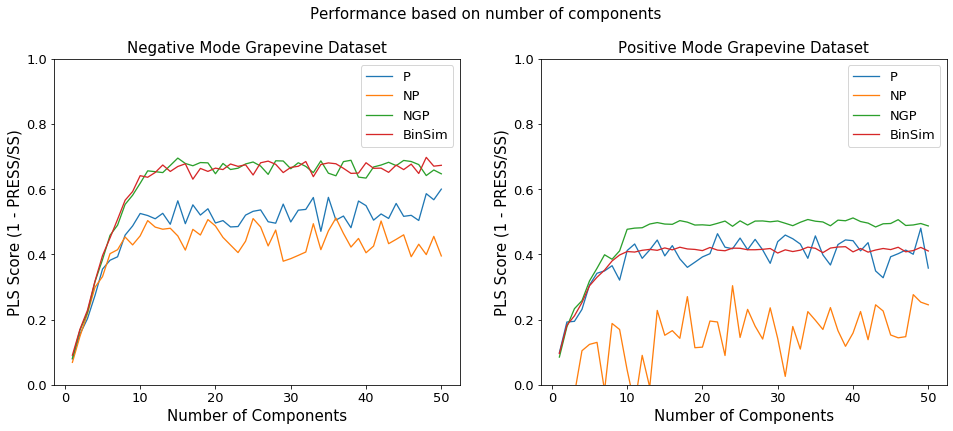

In [117]:
# Plotting the results and adjusting plot parameters
f, axes = plt.subplots(1, 2, figsize = (16,6))
quadrant = [axes[0], axes[1]]
plt.suptitle('Performance based on number of components', fontsize = 15, x = 0.5, y = 1)

for name, data in PLS_optim.items():
    
    if name.endswith('neg'):
        # Negative Grapevine Dataset
        quadrant[0].plot(range(1,51),data)
        quadrant[0].set_xlabel('Number of Components', fontsize=15)
        quadrant[0].set_ylabel('PLS Score (1 - PRESS/SS)', fontsize=15)
        quadrant[0].set_title('Negative Mode Grapevine Dataset', fontsize=15)
        quadrant[0].tick_params(axis='both', which='major', labelsize=13)
        quadrant[0].legend(('P', 'NP', 'NGP', 'BinSim'), fontsize=13)
        quadrant[0].set_ylim([0, 1])
    
    if name.endswith('pos'):
        # Positive Grapevine Dataset
        quadrant[1].plot(range(1,51),data)
        quadrant[1].set_xlabel('Number of Components', fontsize=15)
        quadrant[1].set_ylabel('PLS Score (1 - PRESS/SS)', fontsize=15)
        quadrant[1].set_title('Positive Mode Grapevine Dataset', fontsize=15)
        quadrant[1].tick_params(axis='both', which='major', labelsize=13)
        quadrant[1].legend(('P', 'NP', 'NGP', 'BinSim'), fontsize=13)
        quadrant[1].set_ylim([0, 1])

For the differently-treated Negative Grapevine Datasets (Alignment 1-2), PLS-DA models were built with 11 components.

For the differently-treated Positive Grapevine Datasets (Alignment 1-2), PLS-DA models were built with 13 components.

### Application of PLS-DA - Part of Fig. 3.5 and Suppl. Fig. 6.6

We can now transform the PLS algorithm (PLS2 algorithm used) to give classification of samples instead of regression using a decision rule to interpret the y_pred result given for each test sample and decide what group it belongs to. In this case a simple rule of the group with the highest number (closer to 1) is decided to be the group to which said sample belongs to - naive MAX rule. Models were evaluated according to their predictive accuracy estimated by 3-fold cross-validation.

Use of function `model_PLSDA` of multianalysis.py file. See this file to see the application of this function more in-depth (used `PLSRegression` from scikit-learn).

3 different feature importance metrics (feat_type):

- VIP (Variable Importance/Influence in Projection) - used in dissertation (slowest)
- Coef. (regression coefficients - sum)
- Weights (Sum of the X-weights for each feature)

In [118]:
# Dictionaries to store results
PLS_accu = {}
PLS_score = {}
PLS_feat = {}

In [119]:
%%capture --no-stdout
# For each differently-treated dataset, fit PLS-DA models on 200 randomly sampled folds (for stratified 3-fold cross validation)
# Store results in dictionaries (results for 200 iterations).
for name, data in datasets.items():
    print(f'Fitting PLS-DA for {name} ...', end='')
    if name.endswith('neg'):
        accu, score, u, imp_features = ma.model_PLSDA(data, n_comp = 11, iter_num = 200, feat_type = 'VIP')
    elif name.endswith('pos'):
        accu, score, u, imp_features = ma.model_PLSDA(data, n_comp = 13, iter_num = 200, feat_type = 'VIP')
    PLS_accu[name] = accu
    PLS_score[name] = score
    PLS_feat[name] = imp_features
    print(f'done')    

Fitting PLS-DA for P_neg ...done
Fitting PLS-DA for NP_neg ...done
Fitting PLS-DA for NGP_neg ...done
Fitting PLS-DA for BinSim_neg ...done
Fitting PLS-DA for P_pos ...done
Fitting PLS-DA for NP_pos ...done
Fitting PLS-DA for NGP_pos ...done
Fitting PLS-DA for BinSim_pos ...done


#### Results of the PLS-DA - Performance (Predictive Accuracy) 

#### Negative Grapevine Dataset - Part of Fig. 3.5

Predictive Accuracy of PLS-DA models - Negative Grapevine Dataset


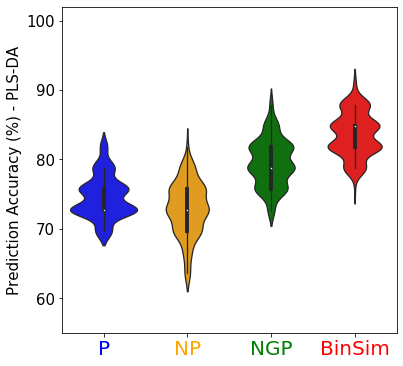

In [120]:
# Plot the distribution of prediction accuracy of the 200 iterations of models built from the differently-treated datasets
# Adjust Parameters
f, ax = plt.subplots(figsize=(6,6))
colors = ['blue','orange','green','red']
data=pd.DataFrame.from_dict(PLS_accu).iloc[:,:4] * 100
data.columns = ['P', 'NP', 'NGP', 'BinSim']
sns.violinplot(data=data, palette = colors, alpha = 0.5)
plt.ylabel('Prediction Accuracy (%) - PLS-DA', fontsize = 15)
plt.ylim([55,102])
ax.tick_params(axis='x', which='major', labelsize= 20)
ax.tick_params(axis='y', which='major', labelsize= 15)

for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)

#plt.savefig('PLSDA-NGD')
print('Predictive Accuracy of PLS-DA models - Negative Grapevine Dataset')
plt.show()

#### Positive Grapevine Dataset - Part of Suppl. Fig. 6.6

Predictive Accuracy of PLS-DA models - Positive Grapevine Dataset


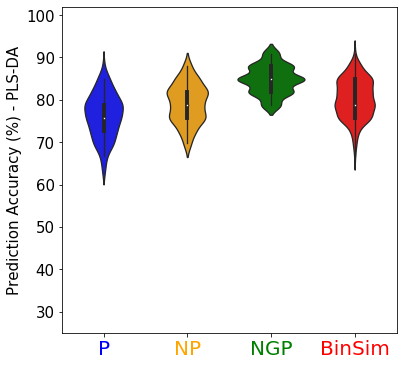

In [121]:
# Plot the distribution of prediction accuracy of the 200 iterations of models built from the differently-treated datasets
# Adjust Parameters
f, ax = plt.subplots(figsize=(6,6))
colors = ['blue','orange','green','red']
data=pd.DataFrame.from_dict(PLS_accu).iloc[:,4:] * 100
data.columns = ['P', 'NP', 'NGP', 'BinSim']
sns.violinplot(data=data, palette = colors, alpha = 0.5)
plt.ylabel('Prediction Accuracy (%) - PLS-DA', fontsize = 15)
plt.ylim([25,102])
ax.tick_params(axis='x', which='major', labelsize= 20)
ax.tick_params(axis='y', which='major', labelsize= 15)

for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)
#plt.title('PLS-DA', fontsize=20)

#plt.savefig('PLSDA-PGD')
print('Predictive Accuracy of PLS-DA models - Positive Grapevine Dataset')
plt.show()

#### Info for Fig. 3.5 and Suppl. Fig. 6.6 and other info

In [122]:
# Average Accuracy across the iterations for each differently-treated dataset
Accuracy = {}
Accuracy_std = {}
for name in PLS_score.keys():
    Accuracy[name] = np.mean(PLS_accu[name])
    Accuracy_std[name] = np.std(PLS_accu[name])

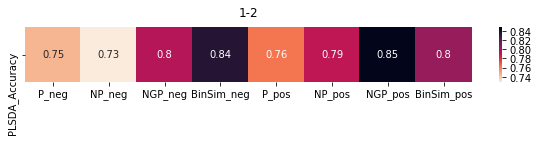

In [123]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys()).T

f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Accuracy_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Accuracy'])

plt.text(4,-0.2,'1-2', fontsize  = 12, horizontalalignment='center')
plt.show()

In [124]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys(), columns  = ['Accuracy']).T
Accuracy_H.loc['SD'] = list(Accuracy_std.values())[:8]
Accuracy_H.T

,Accuracy,SD
P_neg,0.745758,0.029966
NP_neg,0.729394,0.038272
NGP_neg,0.795455,0.033436
BinSim_neg,0.835909,0.030646
P_pos,0.763333,0.051461
NP_pos,0.791970,0.045925
NGP_pos,0.847727,0.033256
BinSim_pos,0.803333,0.045048


### Characteristics of the features considered as important in the differently-treated datasets (Negative and Positive)

Same process as applied for Random Forest.

In [125]:
# Getting the number of samples, groups, ratios for each important feature, magnitude for most important feature
# and identification of important features (in negative and positive GD)
ev_PLS = []
magni_PLS = []
imp_feat_id_PLS_neg = {}
imp_feat_id_PLS_pos = {}

for name in PLS_feat:
    # Choose the respective original spectra for each differently treated dataset
    if name.endswith('neg'):
        #continue
        Spectra = aligned_all_neg
    elif name.endswith('pos'):
        #continue
        Spectra = aligned_all_pos
    #elif name.endswith('neg2'):
        #continue
        #Spectra = aligned_all_neg2
    #elif name.endswith('pos2'):
        #continue
        #Spectra = aligned_all_pos2
    
    # Important Features
    imp_features = PLS_feat[name]
    
    ratio = []
    nsamples = []
    n_groups = []
    imp_feat_id_temp = []
    
    # Top 2% (rounded)
    number = round(0.02*len(Spectra))
    magni_PLS.append(imp_features[0][1]/(1/len(Spectra))) # Calculate how many times feature is more important than average
    
    for i in range(number): # Iterate for only the number of features considered as important

        ngroups = {}
        line = Spectra.loc[imp_features[i][2],:].notnull() # Identify feature in Spectra
        nsamples.append(line.sum()) # Count how many samples the feature appears in
        
        # Count how many groups the feature appears in
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.cdl.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        
        # Calculate the ratio of number of samples to number of groups the feature appears in
        ratio.append(nsamples[-1]/n_groups[-1])
        
        # Store identification of feature
        imp_feat_id_temp.append(imp_features[i][2])
    
    # Organizing info in a dataframe and store it in 'ev_PLS'
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev_PLS.append(df)
    
    # Storing important feature identification
    if name.endswith('neg'):
        imp_feat_id_PLS_neg[name] = imp_feat_id_temp
    elif name.endswith('pos'):
        imp_feat_id_PLS_pos[name] = imp_feat_id_temp
    #print(ev[4])

In [126]:
# Calculating medians of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []

# For each DataFrame in 'ev_PLS'
for i in range(len(ev_PLS)):
    # Calculate and store the median for the sample number, group number and ratio
    samples_m.append(np.median(ev_PLS[i].iloc[:,0]))
    groups_m.append(np.median(ev_PLS[i].iloc[:,1]))
    ratio_m.append(np.median(ev_PLS[i].iloc[:,2]))
    
# Organize information in a DataFrame
df = pd.DataFrame(columns = ['Sample Nº', 'Group nº', 'Ratio'], index = [i  for i in PLS_feat])
df['Sample Nº'] = samples_m
df['Group nº'] = groups_m
df['Ratio'] = ratio_m
#print(df)

# Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"Sample Nº": None, "Group nº": None, 'Ratio':None}, index=[''])
df = pd.concat([df.iloc[:4], line, df.iloc[4:8]])

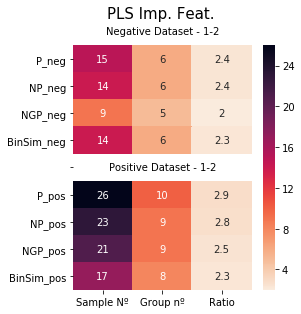

In [127]:
# Plot a Heatmap with the median number of samples and groups features appear in
f, ax = plt.subplots(figsize=(4, 4.5))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.suptitle('PLS Imp. Feat.', fontsize = 15, x = 0.43, y = 1)
plt.text(1.5,-0.5,'Negative Dataset - 1-2',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,4.5,'Positive Dataset - 1-2',horizontalalignment='center', verticalalignment='center')
plt.show()

Distribution of number of samples important features of PLS-DA models appear in - Negative Grapevine Dataset


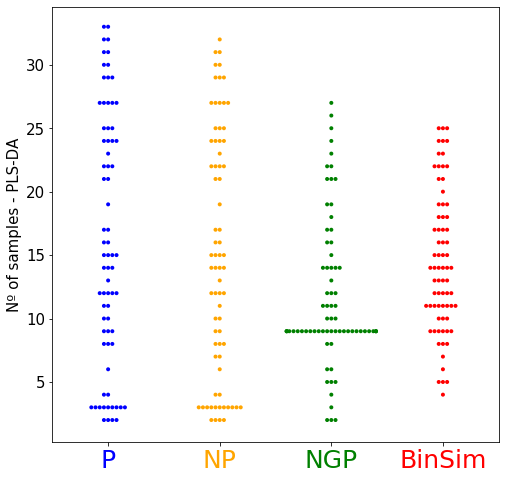

In [128]:
# Plot the swarm plot and adjust parameters
f, ax = plt.subplots(figsize=(8,8))
data = [ev_PLS[i]['nsamples'] for i in range(4)] #range(len(ev_PLS))]
#print(data)
#sns.violinplot(data=data)
sns.swarmplot(data=data, size = 4, palette = ['blue','orange','green','red'])
ax.set(xticklabels = ['P','NP','NGP','BinSim'])
ax.tick_params(axis='x', which='major', labelsize=25)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.ylabel('Nº of samples - PLS-DA', fontsize = 15)
colors = ['blue','orange','green','red']
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)

#plt.savefig('PLSDA-NGD-IF')
print('Distribution of number of samples important features of PLS-DA models appear in - Negative Grapevine Dataset')
plt.show()

Distribution of number of samples important features of PLS-DA models appear in - Positive Grapevine Dataset


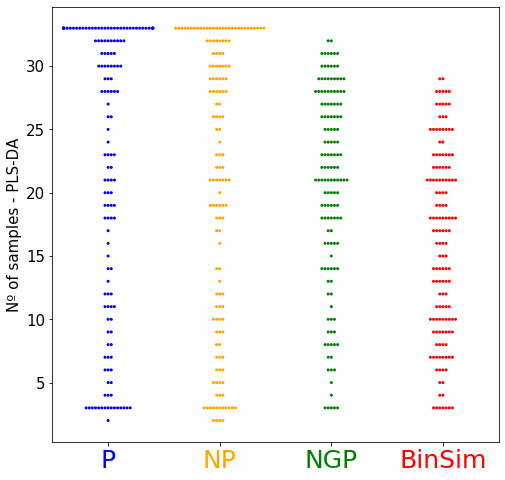

In [129]:
# Plot the swarm plot and adjust parameters
f, ax = plt.subplots(figsize=(8,8))
data = [ev_PLS[i]['nsamples'] for i in range(4,8)] #range(len(ev_PLS))]
#print(data)
#sns.violinplot(data=data)
sns.swarmplot(data=data, size = 3, palette = ['blue','orange','green','red'])
ax.set(xticklabels = ['P','NP','NGP','BinSim'])
ax.tick_params(axis='x', which='major', labelsize=25)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.ylabel('Nº of samples - PLS-DA', fontsize = 15)
colors = ['blue','orange','green','red']
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)

#plt.savefig('PLSDA-NGD-IF')
print('Distribution of number of samples important features of PLS-DA models appear in - Positive Grapevine Dataset')
plt.show()

In [130]:
print('Magnitude of most important features for each case:')
for i in range(len(PLS_feat.keys())):
    print(list(PLS_feat.keys())[i], '   \t', magni_PLS[i])

Magnitude of most important features for each case:
P_neg    	 51487.735640981584
NP_neg    	 54379.7324113002
NGP_neg    	 10788.762078304353
BinSim_neg    	 7407.132409253764
P_pos    	 86640.66934387262
NP_pos    	 90550.22691651243
NGP_pos    	 33122.15986301707
BinSim_pos    	 17361.652373849072


#### Intersections of Important Features used to build each differently-treated dataset - PLS-DA

#### Negative Grapevine Dataset - Information (after some calculations) for Fig 3.6

Be careful with features present in all sets, in 3 of the sets and in 2 sets for calculating values for Venn Diagram

Easier ways to obtain the results directly are available but since it is already done.

In [131]:
# Easier to write
name = imp_feat_id_PLS_neg

# How many Features are in at least one of the sets of important features of the differently-treated dataset
union = len(np.union1d(np.union1d(np.union1d(name['P_neg'],name['NP_neg']), name['NGP_neg']), name['BinSim_neg']))
print('Nº of different features across the sets of important features:', union)

# How many Features are in all sets of important features of the differently-treated dataset
intersection = len(np.intersect1d(np.intersect1d(np.intersect1d(name['P_neg'],name['NP_neg']), name['NGP_neg']),
                                  name['BinSim_neg']))
print('Nº of features present in all sets of important features:', intersection, '\n')

# Build DataFrame for pairwise intersection of the sets of important features
intersec = pd.DataFrame(np.zeros((4,4)), index=name.keys(), columns=name.keys())
for i in name.keys():
    for j in name.keys():
        intersec.loc[i,j] = len(np.intersect1d(name[i],name[j]))#/len(name[i])     
        
# Intersections of 3 of the 4 different sets of important features
for i,j,m in itertools.combinations(name,3):
    print('Sets of features considered:',i,',',j,',',m,'.',
          'Number of features in the 3 sets:', len(np.intersect1d(np.intersect1d(name[i],name[j]), name[m])))

print('\nDataframe with the intersection of two set of important features for each pairwise combination:')    
print(intersec)

Nº of different features across the sets of important features: 171
Nº of features present in all sets of important features: 10 

Sets of features considered: P_neg , NP_neg , NGP_neg . Number of features in the 3 sets: 21
Sets of features considered: P_neg , NP_neg , BinSim_neg . Number of features in the 3 sets: 12
Sets of features considered: P_neg , NGP_neg , BinSim_neg . Number of features in the 3 sets: 11
Sets of features considered: NP_neg , NGP_neg , BinSim_neg . Number of features in the 3 sets: 11

Dataframe with the intersection of two set of important features for each pairwise combination:
            P_neg  NP_neg  NGP_neg  BinSim_neg
P_neg        73.0    67.0     22.0        13.0
NP_neg       67.0    73.0     22.0        13.0
NGP_neg      22.0    22.0     73.0        29.0
BinSim_neg   13.0    13.0     29.0        73.0


#### Positive Grapevine Dataset - Information (after some calculations) for Suppl. Fig. 6.8

Be careful with features present in all sets, in 3 of the sets and in 2 sets for calculating values for Venn Diagram.

Easier ways to obtain the results directly are available but since it is already done.

In [132]:
# Easier to write
name = imp_feat_id_PLS_pos

# How many Features are in at least one of the sets of important features of the differently-treated dataset
union = len(np.union1d(np.union1d(np.union1d(name['P_pos'],name['NP_pos']), name['NGP_pos']), name['BinSim_pos']))
print('Nº of different features across the sets of important features:', union)

# How many Features are in all sets of important features of the differently-treated dataset
intersection = len(np.intersect1d(np.intersect1d(np.intersect1d(name['P_pos'],name['NP_pos']), name['NGP_pos']),
                                  name['BinSim_pos']))
print('Nº of features present in all sets of important features:', intersection, '\n')

# Build DataFrame for pairwise intersection of the sets of important features
intersec = pd.DataFrame(np.zeros((4,4)), index=name.keys(), columns=name.keys())
for i in name.keys():
    for j in name.keys():
        intersec.loc[i,j] = len(np.intersect1d(name[i],name[j]))#/len(name[i])     
        
# Intersections of 3 of the 4 different sets of important features
for i,j,m in itertools.combinations(name,3):
    print('Sets of features considered:',i,',',j,',',m,'.',
          'Number of features in the 3 sets:', len(np.intersect1d(np.intersect1d(name[i],name[j]), name[m])))

print('\nDataframe with the intersection of two set of important features for each pairwise combination:')    
print(intersec)

Nº of different features across the sets of important features: 333
Nº of features present in all sets of important features: 18 

Sets of features considered: P_pos , NP_pos , NGP_pos . Number of features in the 3 sets: 38
Sets of features considered: P_pos , NP_pos , BinSim_pos . Number of features in the 3 sets: 19
Sets of features considered: P_pos , NGP_pos , BinSim_pos . Number of features in the 3 sets: 23
Sets of features considered: NP_pos , NGP_pos , BinSim_pos . Number of features in the 3 sets: 27

Dataframe with the intersection of two set of important features for each pairwise combination:
            P_pos  NP_pos  NGP_pos  BinSim_pos
P_pos       141.0   109.0     44.0        25.0
NP_pos      109.0   141.0     53.0        28.0
NGP_pos      44.0    53.0    141.0        61.0
BinSim_pos   25.0    28.0     61.0       141.0


### Example of models built with the full dataset and sample representation on the two most important Components/Latent Variables

In [133]:
def plot_PLSDA(principaldf, label_colors, components=(1,2), title="PLS-DA", ax=None):
    "Plot the projection of samples in the 2 main components of a PLS-DA model."
    
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    col_c1_name, col_c2_name = principaldf.columns[[loc_c1, loc_c2]]
    
    with sns.axes_style("whitegrid"):
        #ax.axis('equal')
        ax.set_xlabel(f'{col_c1_name}', fontsize = 15)
        ax.set_ylabel(f'{col_c2_name}', fontsize = 15)

        unique_labels = principaldf['Label'].unique()

        for lbl in unique_labels:
            subset = principaldf[principaldf['Label']==lbl]
            ax.scatter(subset[col_c1_name],
                       subset[col_c2_name],
                       s=50, color=label_colors[lbl], label=lbl)

        ax.legend(framealpha=1)
        ax.set_title(title, fontsize=15)

#### NGP pre-treated Negative GD - Alignment: 1-2

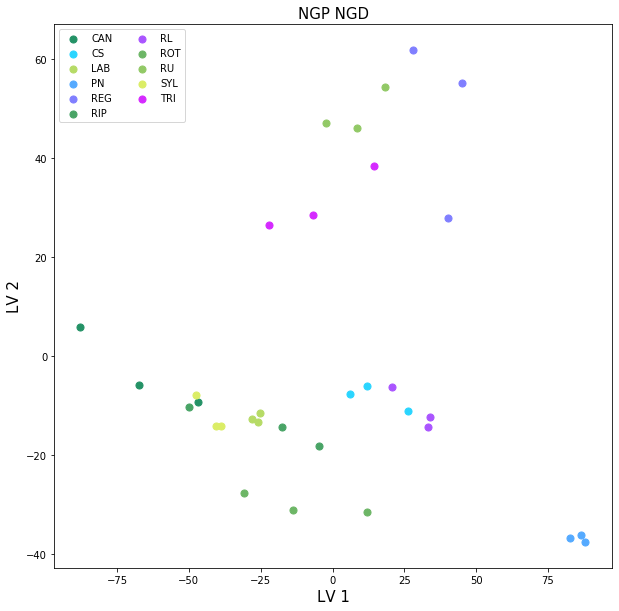

In [134]:
n_components = 11

plsreg_GPneg = ma.PLSscores_with_labels(NGP_neg, n_components)

fig, axl = plt.subplots(1,1, figsize=(10,10))
plot_PLSDA(plsreg_GPneg, label_colors, title="NGP NGD", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.show()

#### BinSim treated Negative GD - Alignment: 1-2

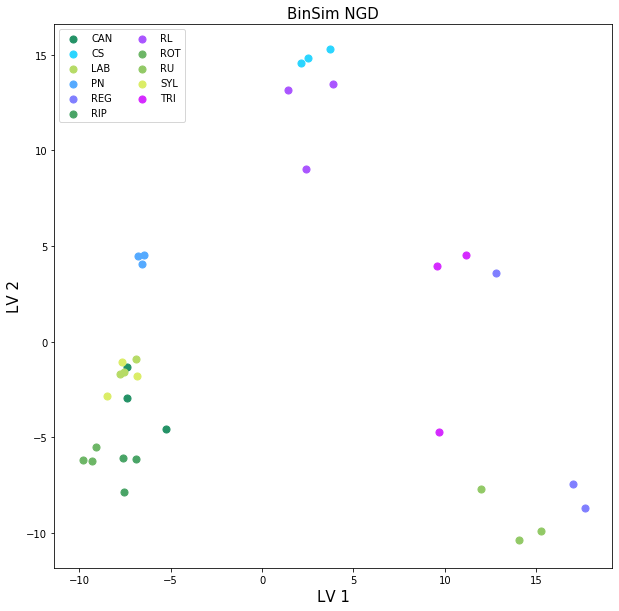

In [135]:
n_components = 11

plsreg_GPneg = ma.PLSscores_with_labels(bin_neg, n_components)

fig, axl = plt.subplots(1,1, figsize=(10,10))
plot_PLSDA(plsreg_GPneg, label_colors, title="BinSim NGD", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.show()

## Permutation Tests - Part of Suppl. Fig. 6.7

Permutation tests is based on shuffling the labels of the different samples, shuflling the groups where they belong with the intent to see if the classifier tested, whether it is Random Forest or PLS-DA found a significant class structure in the data - assess the significance of the predictive accuracy results. 

For that a random 3-fold cross-validation is performed on the original dataset (to serve as a comparation point) and 1000 permutations of datasets with labels randomly shuffled around with the model being evaluated by how good the predictions the model does of the test data is. 

The empirical p-value is given by (the number of times the permutation accuracy was bigger than the random 3-fold cross-validation made with the original dataset + 1) / (number of permutations + 1) (source: Ojala2010 - error should be the opposite of the accuracy).

Histograms with the prediction accuracy of the different permutations were plotted and compared to the accuracy got with the original dataset.

### Permutation Tests - Random Forests (very slow)

Use of `permutation_RF` function from multianalysis.py. See details about the application of this function in the multianalysis.py file.

In [136]:
# Store results
CV = {}
PMs = {}
pvalue = {}

In [137]:
all_data = (P_neg, NP_neg, NGP_neg, bin_neg, P_pos, NP_pos, NGP_pos, bin_pos)
names = ('P Treatment', 'NP Treatment', 'NGP Treatment', 'BinSim Treatment',
         'P Treatment_pos', 'NP Treatment_pos', 'NGP Treatment_pos', 'BinSim Treatment_pos')

# Application of permutations tests (with 1000 iterations)
for name, data in zip(names, all_data):
    print(f'Permutation test (Random Forest) for {name} ...')
    permuta = ma.permutation_RF(data, iter_num=1000, n_fold=3)
    CV[name] = permuta[0]
    PMs[name] = permuta[1]
    pvalue[name] = permuta[2]
    print('Done!')

Permutation test (Random Forest) for P Treatment ...
Done!
Permutation test (Random Forest) for NP Treatment ...
Done!
Permutation test (Random Forest) for NGP Treatment ...
Done!
Permutation test (Random Forest) for BinSim Treatment ...
Done!
Permutation test (Random Forest) for P Treatment_pos ...
Done!
Permutation test (Random Forest) for NP Treatment_pos ...
Done!
Permutation test (Random Forest) for NGP Treatment_pos ...
Done!
Permutation test (Random Forest) for BinSim Treatment_pos ...
Done!


Permutation Test - Negative Grapevine Dataset - Random Forest


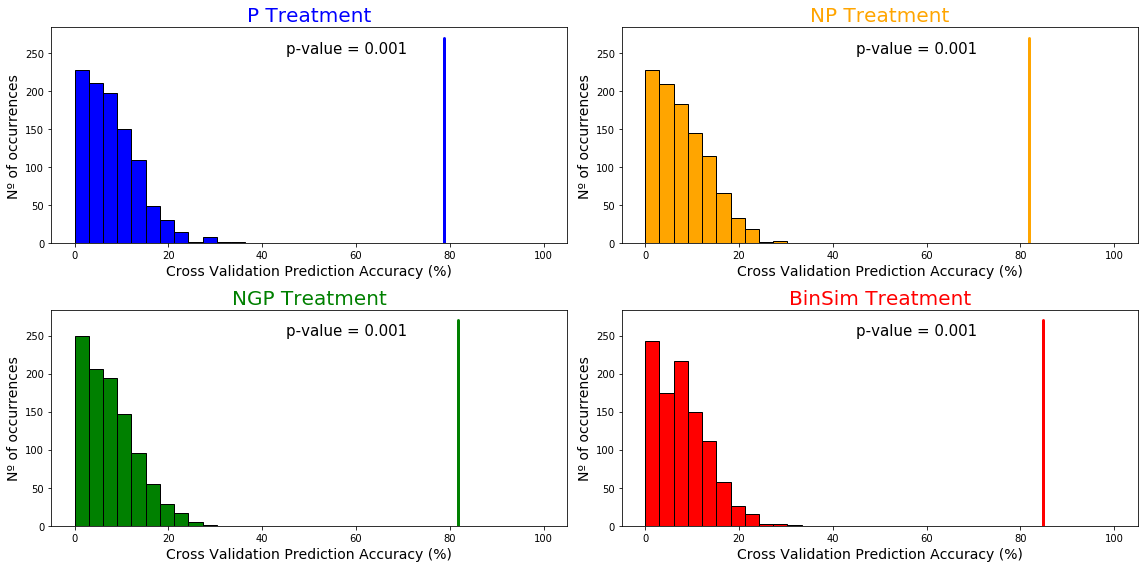

In [138]:
print('Permutation Test - Negative Grapevine Dataset - Random Forest')
# Plot the Permutations test results - Histogram of predictive accuracies of permutated labels and comparison to reference
# predictive accuracy
f, axes = plt.subplots(2, 2, figsize = (16,8))
colors = ['blue', 'orange', 'green', 'red']
Names = ['P Treatment','NP Treatment','NGP Treatment','BinSim Treatment']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,270]
n_labels = len(NGP_neg.cdl.labels)

# Setting paramaters
for q, name, color in zip(quadrant, Names, colors):
    q.hist(np.array(PMs[name])*100, n_labels, range=(0, 100.01), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]* 100], ylim, '-', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name], solid_capstyle='round')
    #q.set(xlabel='Cross Validation Prediction Accuracy (%)', ylabel='Nº of occurrences', fontsize=12)
    q.set_xlabel('Cross Validation Prediction Accuracy (%)', fontsize=14)
    q.set_ylabel('Nº of occurrences', fontsize=14)
    q.text(45,250, 'p-value = %.3f' % pvalue[name], fontsize = 15)
    q.set_title(name, size = 20, color = color)

plt.tight_layout()
#plt.savefig('Perm-NGD-RF')

Permutation Test - Positive Grapevine Dataset - Random Forest


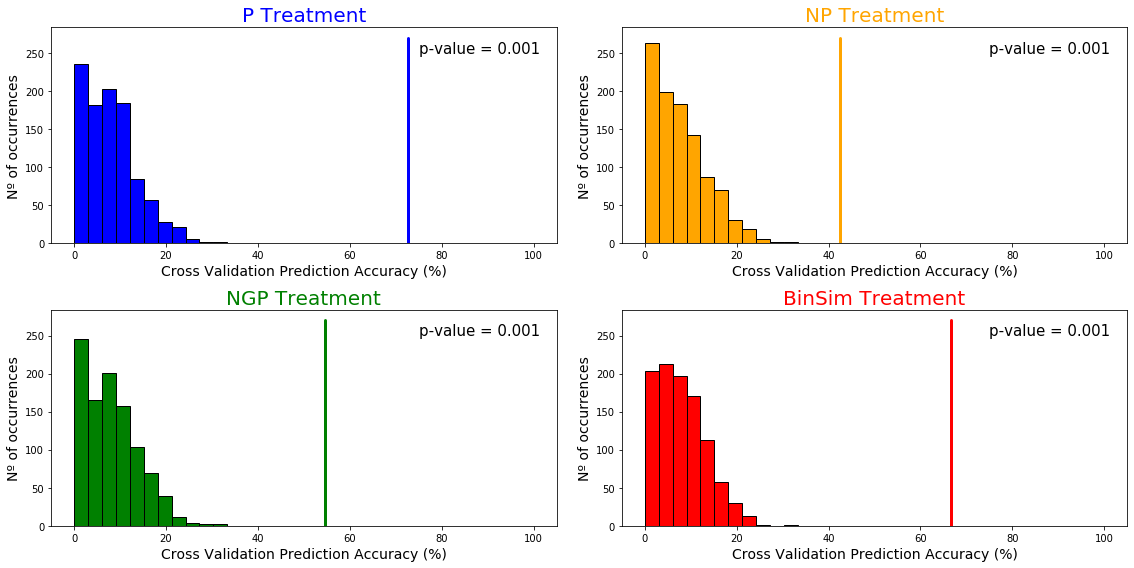

In [139]:
print('Permutation Test - Positive Grapevine Dataset - Random Forest')
# Plot the Permutations test results - Histogram of predictive accuracies of permutated labels and comparison to reference
# predictive accuracy
f, axes = plt.subplots(2, 2, figsize = (16,8))

# Data to help the plot
colors = ['blue', 'orange', 'green', 'red']
Names = ['P Treatment_pos', 'NP Treatment_pos', 'NGP Treatment_pos', 'BinSim Treatment_pos']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,270]
n_labels = len(NGP_neg.cdl.labels)

# Setting the parameters of the figure
for q, name, color in zip(quadrant, Names, colors):
    q.hist(np.array(PMs[name])*100, n_labels, range=(0, 100.01), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]* 100], ylim, '-', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name], solid_capstyle='round')
    #q.set(xlabel='Cross Validation Prediction Accuracy (%)', ylabel='Nº of occurrences', fontsize=12)
    q.set_xlabel('Cross Validation Prediction Accuracy (%)', fontsize=14)
    q.set_ylabel('Nº of occurrences', fontsize=14)
    q.text(75,250, 'p-value = %.3f' % pvalue[name], fontsize = 15)
    name = name.split('_')[0]
    q.set_title(name, size = 20, color = color)

plt.tight_layout()
#plt.savefig('Perm-PGD-RF')

### Permutation Tests - PLS-DA (slow)

Use of `permutation_PLSDA` function from multianalysis.py. See details about the application of this function in the multianalysis.py file.

In [140]:
# Store Results
CV_PLS = {}
PMs_PLS = {}
pvalue_PLS = {}

In [141]:
all_data = (P_neg, NP_neg, NGP_neg, bin_neg, P_pos, NP_pos, NGP_pos, bin_pos)
names = ('P Treatment', 'NP Treatment', 'NGP Treatment', 'BinSim Treatment',
         'P Treatment_pos', 'NP Treatment_pos', 'NGP Treatment_pos', 'BinSim Treatment_pos')

for name, data in zip(names, all_data):
    print(f'permutation test (PLS-DA) for {name} ...')
    permuta = ma.permutation_PLSDA(data, n_comp=11, iter_num=1000)
    CV_PLS[name] = permuta[0]
    PMs_PLS[name] = permuta[1]
    pvalue_PLS[name] = permuta[2]
    print('Done!')

permutation test (PLS-DA) for P Treatment ...


C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for NP Treatment ...


C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for NGP Treatment ...


C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for BinSim Treatment ...


C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for P Treatment_pos ...


C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for NP Treatment_pos ...


C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for NGP Treatment_pos ...


C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for BinSim Treatment_pos ...


C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\U

Done!


Permutation Test - Negative Grapevine Dataset - PLS-DA


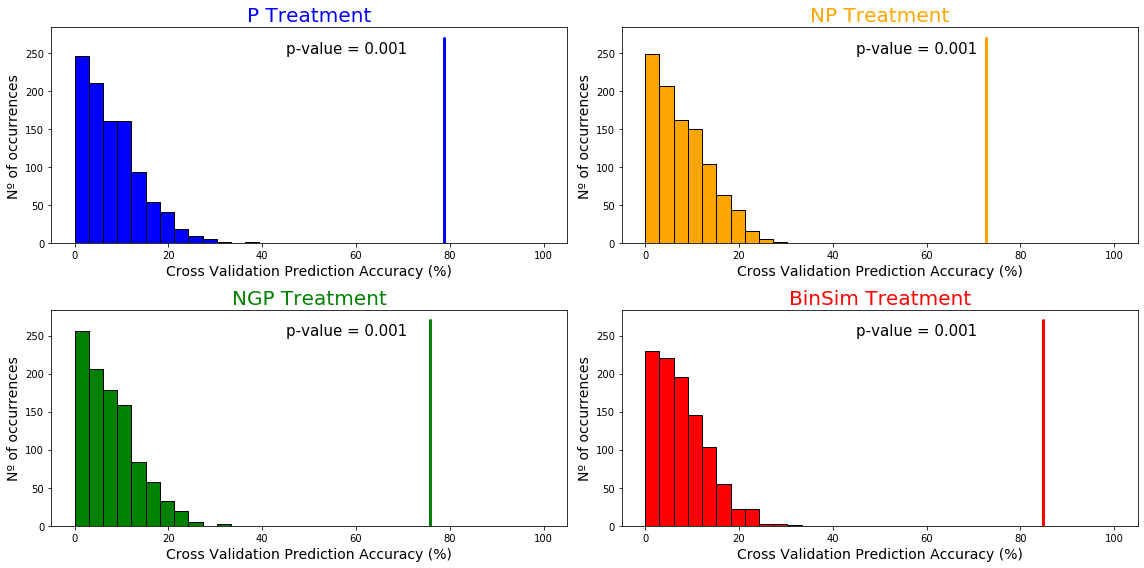

In [142]:
print('Permutation Test - Negative Grapevine Dataset - PLS-DA')
# Plot the Permutations test results - Histogram of predictive accuracies of permutated labels and comparison to reference
# predictive accuracy
f, axes = plt.subplots(2, 2, figsize = (16,8))

Names = ['P Treatment', 'NP Treatment', 'NGP Treatment', 'BinSim Treatment']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,270]
n_labels = len(NGP_neg.cdl.labels)

# Setting the parameters of the figure
for q, name, color in zip(quadrant, Names, colors):
    q.hist(np.array(PMs_PLS[name])*100, n_labels, range=(0, 100.001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]*100], ylim, '-', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name], solid_capstyle='round')
    #q.set(xlabel='Cross Validation Prediction Accuracy (%)', ylabel='Nº of occurrences')
    q.set_xlabel('Cross Validation Prediction Accuracy (%)', fontsize=14)
    q.set_ylabel('Nº of occurrences', fontsize=14)
    q.text(45,250, 'p-value = %.3f' % pvalue_PLS[name], fontsize = 15)
    q.set_title(name, size = 20, color = color)

plt.tight_layout()
#plt.savefig('Perm-NGD-PLSDA')

Permutation Test - Positive Grapevine Dataset - PLS-DA


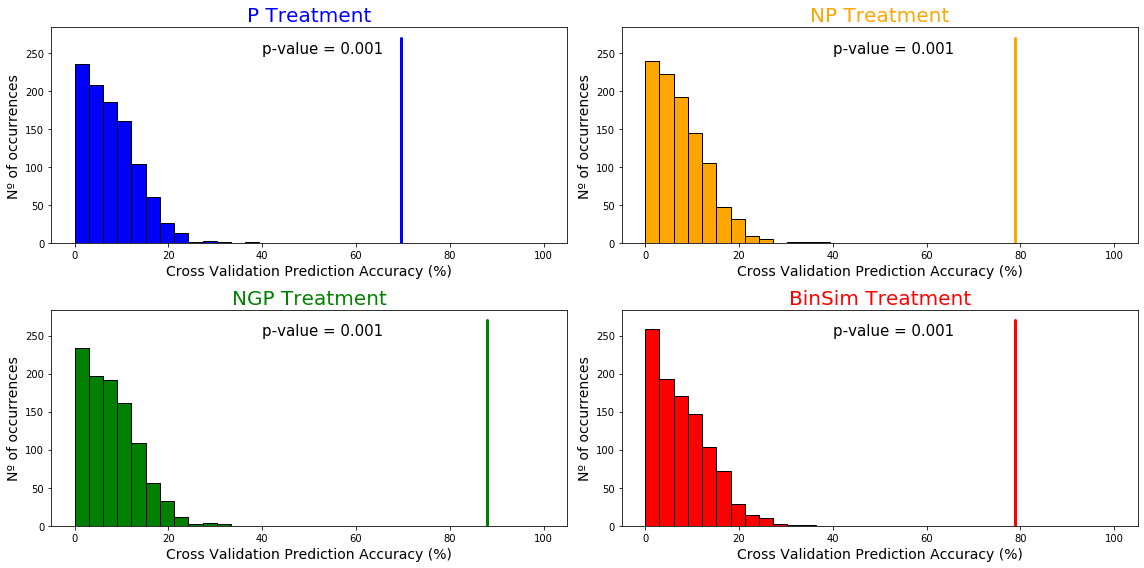

In [143]:
print('Permutation Test - Positive Grapevine Dataset - PLS-DA')
# Plot the Permutations test results - Histogram of predictive accuracies of permutated labels and comparison to reference
# predictive accuracy
f, axes = plt.subplots(2, 2, figsize = (16,8))

Names = ['P Treatment_pos', 'NP Treatment_pos', 'NGP Treatment_pos', 'BinSim Treatment_pos']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,270]
n_labels = len(NGP_neg.cdl.labels)

# Setting the parameters of the figure
for q, name, color in zip(quadrant, Names, colors):
    q.hist(np.array(PMs_PLS[name])*100, n_labels, range=(0, 100.001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]*100], ylim, '-', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name], solid_capstyle='round')
    #q.set(xlabel='Cross Validation Prediction Accuracy (%)', ylabel='Nº of occurrences')
    q.set_xlabel('Cross Validation Prediction Accuracy (%)', fontsize=14)
    q.set_ylabel('Nº of occurrences', fontsize=14)
    q.text(40,250, 'p-value = %.3f' % pvalue_PLS[name], fontsize = 15)
    name = name.split('_')[0]
    q.set_title(name, size = 20, color = color)

plt.tight_layout()
#plt.savefig('Perm-PGD-PLSDA')

### Feature Permutation Test - Incomplete - Not well commented

This takes a long time.

This is a first attempt to use the feature permutation test present in the pyopls python package (installing necessary) as a measure of the significance and importance of the features. This as the normal permutation test shuffles the order of values in each feature. Here, the metric followed to see if this causes a major change in the created model is the X-loading of the first component of said feature. If this X-loading changes in a way to the reference loading (that I still don't comprehend), then the feature is significant.

Importing for stuff needed in feature_permutation_loading.

In [1]:
from sklearn.cross_decomposition import PLSRegression

from joblib import Parallel, delayed

from sklearn.base import is_classifier, clone

from sklearn.utils import indexable, check_random_state

from sys import stderr

Altered version of feature_permutation_loading that accounts for an error they had on their code in pyopls

### Note: This almost a copy of the function in pyopls function

In [131]:
def feature_permutation_loading(estimator, X, y, initial_permutations=100, alpha=0.2, final_permutations=500,
                                random_state=0, n_jobs=None, verbose=0, pre_dispatch='2*n_jobs'):
    """Determine the significance of each feature
    This is done by permuting each feature in X and measuring the loading.
    The feature is considered significant if the loadings are significantly different.
    This is always done with a regular PLS regressor
    PLS-DA should be binarized first.
    Parameters
    ----------
    estimator : estimator object implementing 'fit' with x_loadings_
        The object to use to fit the data. This should have an [n_features, 1] x_loadings_ array. This can be a
        one-component PLS or OPLS model.
    X : array-like, shape = [n_samples, n_features]
        Training vectors, where n_samples is the number of samples and
        n_features is the number of predictors.
    y : array-like, shape = [n_samples, 1]
        Target vector, where n_samples is the number of samples.
        This implementation only supports a single response (target) variable.
    initial_permutations : int
        The number of permutations to perform for all features.
    alpha : float, in range (0, 1)
        The threshold for significance. If a feature is found significant in the first round, it will be retested with
        final_permutations in the second round.
    final_permutations : int
        The number of permutations to perform during the second round to retest points found significant in the first
        round.
    n_jobs : int or None, optional (default=None)
        The number of CPUs to use to do the computation.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.
    verbose : integer, optional
        The verbosity level.
    pre_dispatch : int, or string, optional
        Controls the number of jobs that get dispatched during parallel
        execution. Reducing this number can be useful to avoid an
        explosion of memory consumption when more jobs get dispatched
        than CPUs can process. This parameter can be:
            - None, in which case all the jobs are immediately
              created and spawned. Use this for lightweight and
              fast-running jobs, to avoid delays due to on-demand
              spawning of the jobs
            - An int, giving the exact number of total jobs that are
              spawned
            - A string, giving an expression as a function of n_jobs,
              as in '2*n_jobs'
    random_state : int, RandomState instance or None, optional (default=0)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.
    Returns
    -------
    x_loadings : array [n_features]
        The x_loadings found from non-permuted data.
    permutation_x_loadings: array [n_inner_permutations, n_features]
        The one-component PLS loadings for each permutation in the first round.
    p_values: array [n_features]
        The p-values for each feature. The null hypothesis is that permuting the feature does not change it's weight
        in the one-component PLS model.
    """

    def feature_ind_generator(n_permutations_, feature_inds):
        """
        Repeats each value in feature_inds n_permutations_ times.
        """
        i = 0
        count = 0
        while count < (n_permutations_ * len(feature_inds)):
            yield feature_inds[i]
            count += 1
            if (count % n_permutations_) == 0:
                i += 1

    def _log(txt):
        if verbose in range(1, 51):
            stderr.write(txt + '\n')
        if verbose > 50:
            print(txt)

    random_state = check_random_state(random_state)
    n_features = X.shape[1]
    x_loadings = np.ravel(estimator.fit(X, y).x_loadings_)
    loading_max = np.max((x_loadings, -1 * x_loadings), axis=0)
    loading_min = np.min((x_loadings, -1 * x_loadings), axis=0)

    _log('Performing initial permutation tests.')
    permutation_x_loadings = Parallel(n_jobs=n_jobs, verbose=verbose, pre_dispatch=pre_dispatch)(
        delayed(_feature_permutation_loading)(
            clone(estimator), _feature_shuffle(X, feature_ind, random_state), y, x_loadings, feature_ind)
        for feature_ind in feature_ind_generator(initial_permutations, [i for i in range(n_features)]))
    permutation_x_loadings = np.array(permutation_x_loadings).reshape(n_features, initial_permutations).T

    _log('Calculating p values.')
    p_values = Parallel(n_jobs=n_jobs, verbose=verbose, pre_dispatch=pre_dispatch)(
        delayed(_loading_p_value)(permutation_x_loading, upper, lower, initial_permutations)
        for permutation_x_loading, upper, lower in zip(np.hsplit(permutation_x_loadings, n_features),
                                                       loading_max, loading_min)
    )

    p_values = np.array(p_values)
    p_values[p_values > 1] = 1  # if feature_min=feature_max=loading=0 values will be greater than 1
    return x_loadings, permutation_x_loadings, p_values


def _feature_permutation_loading(estimator, X, y, reference_loadings, feature_ind):
    """Auxiliary function for feature_permutation_loading"""
    """Not that since loading only depends on training data, we dont use cross-validation"""
    test_loadings = np.ravel(estimator.fit(X, y).x_loadings_)
    # make directions the same
    err1 = (np.sum(np.square(test_loadings[:feature_ind] - reference_loadings[:feature_ind]))
            + np.sum(np.square(test_loadings[feature_ind:] - reference_loadings[feature_ind:])))
    err2 = (np.sum(np.square(test_loadings[:feature_ind] + reference_loadings[:feature_ind]))
            + np.sum(np.square(test_loadings[feature_ind:] + reference_loadings[feature_ind:])))
    sign = -1 if err2 < err1 else 1
    return sign * test_loadings[feature_ind]


def _feature_shuffle(X, feature_ind, random_state):
    X = X.copy()
    random_state.shuffle(X[:, feature_ind])
    return X


def _loading_p_value(permutation_loadings, upper, lower, n_permutations):
    return (np.sum(permutation_loadings >= upper) + np.sum(permutation_loadings <= lower) + 1) / (n_permutations + 1)


In [132]:
feat_perm_res = {}
plsda = plsda = PLSRegression(n_components=1, scale=False)

In [133]:
matrix = ma._generate_y_PLSDA(all_labels, list(unique_labels), False)

In [134]:
for i in datasets:
    print('Feature permutation test for ... ', i)
    feat_perm_res[i] = feature_permutation_loading(plsda, datasets[i].T.values, matrix, initial_permutations=500, alpha=0.15,
                    final_permutations=500, random_state=0, n_jobs=1, verbose=1, pre_dispatch='2*n_jobs')
    

Feature permutation test for ...  P_neg2


Performing initial permutation tests.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1814500 out of 1814500 | elapsed: 180.6min finished
Calculating p values.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3629 out of 3629 | elapsed:    0.1s finished
Performing initial permutation tests.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Feature permutation test for ...  NP_neg2


[Parallel(n_jobs=1)]: Done 1814000 out of 1814000 | elapsed: 191.7min finished
Calculating p values.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3628 out of 3628 | elapsed:    0.1s finished
Performing initial permutation tests.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Feature permutation test for ...  NGP_neg2


[Parallel(n_jobs=1)]: Done 1814000 out of 1814000 | elapsed: 194.3min finished
Calculating p values.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3628 out of 3628 | elapsed:    0.1s finished
Performing initial permutation tests.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Feature permutation test for ...  bin_neg2


[Parallel(n_jobs=1)]: Done 1814500 out of 1814500 | elapsed: 886.5min finished
Calculating p values.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3629 out of 3629 | elapsed:    0.1s finished
Performing initial permutation tests.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Feature permutation test for ...  P_pos2


KeyboardInterrupt: 

In [146]:
for i in feat_perm_res:
    print('Nº of significant features of', i, ':', (feat_perm_res[i][2]<0.002).sum())

Nº of significant features of P_neg2 : 521
Nº of significant features of NP_neg2 : 495
Nº of significant features of NGP_neg2 : 2036
Nº of significant features of bin_neg2 : 761


In [186]:
print('Percentage of features considered significant in each case: ')

for i in feat_perm_res:
    print(i, ':', ((feat_perm_res[i][2]<0.002).sum())/(feat_perm_res[i][2]<2).sum()*100)

Percentage of features considered significant in each case: 
P_neg2 : 14.356572058418296
NP_neg2 : 13.6438809261301
NGP_neg2 : 56.119073869900774
bin_neg2 : 20.969964177459353


In [222]:
imp_feat_perm = {}
imp_feat_PLSDA = {}
for i in feat_perm_res:
    print(i)
    feat_num = 0
    imp_feat_temp = []
    for j in range(len(feat_perm_res[i][2])):
        if feat_perm_res[i][2][j] < 0.002:
            imp_feat_temp.append(j)
            feat_num = feat_num + 1
    imp_feat_perm[i] = imp_feat_temp
    #print(feat_num)
    imp_feat_temp = []
    for j in range(feat_num):
        imp_feat_temp.append(PLS_feat[i][j][0])
    imp_feat_PLSDA[i] = imp_feat_temp

P_neg2
NP_neg2
NGP_neg2
bin_neg2


In [223]:
print('Nº and Percentage of features considered significant both in feature permutation and the PLSDA importance measure: ')
for i in imp_feat_perm:
    inter = len(set(imp_feat_perm[i]).intersection(imp_feat_PLSDA[i]))
    print(i, ':', inter/len(imp_feat_perm[i])*100, '% of features corresponding to a total of:', inter, ' features.')
    #print(len(set(imp_feat_perm[i]).intersection(imp_feat_PLSDA[i])))

Nº and Percentage of features considered significant both in feature permutation and the PLSDA importance measure: 
P_neg2 : 10.556621880998081 % of features corresponding to a total of: 55  features.
NP_neg2 : 10.1010101010101 % of features corresponding to a total of: 50  features.
NGP_neg2 : 36.2475442043222 % of features corresponding to a total of: 738  features.
bin_neg2 : 17.082785808147175 % of features corresponding to a total of: 130  features.


In [229]:
intersec = pd.DataFrame(np.zeros((4,4)), columns = imp_feat_perm.keys(), index = imp_feat_perm.keys())
for i in imp_feat_perm:
    for j in imp_feat_perm:
        intersec.loc[i,j] = len(np.intersect1d(imp_feat_perm[i],imp_feat_perm[j]))#/len(name[i])
intersec

,P_neg2,NP_neg2,NGP_neg2,bin_neg2
P_neg2,521.0,396.0,313.0,442.0
NP_neg2,396.0,495.0,310.0,441.0
NGP_neg2,313.0,310.0,2036.0,520.0
bin_neg2,442.0,441.0,520.0,761.0
